# Income-Prediction-Classification

# Imports

In [33]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif
from sklearn.preprocessing import PowerTransformer, StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline as sklearnPipeline
from sklearn.model_selection import RepeatedStratifiedKFold, RandomizedSearchCV
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer, confusion_matrix

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from sklearn.dummy import DummyClassifier

# Functions

In [65]:
def check_for_nulls_dupes(df):
  print(f"The amount of Null Values: {df.isna().sum()}")
  print(f"The amount of Duplicated Values {df.duplicated().sum()}")

def check_class_imbalance(target):
  unique, counts = np.unique(target, return_counts=True)
  
  plt.figure(figsize=(10, 7))
  plt.pie(counts, labels=unique, startangle=140, autopct="%1.1f%%")
  plt.title("Target Class Breakdown")
  plt.legend()
  plt.show()
  
  plt.figure(figsize=(10, 7))
  sns.countplot(x=target)
  plt.xlabel("Target Class Breakdown")
  plt.ylabel("Counts")
  plt.show()

def plot_distribution(df, kind):
  
  plt.figure(figsize=(16,16))
  columns = len(df.columns)
  rows = (columns + 3) //4
  
  for idx, col in enumerate(df.columns):
    if col == "Type":
      continue
    plt.subplot(rows ,4, idx+1)
    sns.histplot(df[col], kde=True) if kind == "hist" else plt.boxplot(df[col])
    plt.title(f"Distribuition of {col}")
    plt.ylabel("Counts")

  plt.tight_layout()
  plt.show()

def dist_plot(df):
  
  for col in df.columns:
    salary_skewness = df[col].skew()
    salary_kurtosis = df[col].kurtosis()

    plt.figure(figsize=(10, 6))
    sns.histplot(df[col], kde=True, color='blue')
    plt.title(f'Distribution of {col} with Skewness and Kurtosis')
    plt.xlabel(col)
    plt.ylabel('Frequency')

    plt.text(x=0.95, y=0.85, s=f"Skewness: {salary_skewness:.2f}", transform=plt.gca().transAxes, horizontalalignment='right')
    plt.text(x=0.95, y=0.80, s=f"Kurtosis: {salary_kurtosis:.2f}", transform=plt.gca().transAxes, horizontalalignment='right')

    plt.grid(True)
    plt.show()

def aggregate_dataset(df, interested_columns, agg_col, function):
  
  plt.figure(figsize=(12,12))
  columns = len(df.columns)
  rows = (columns + 3) //4
  
  for idx, col in enumerate(interested_columns):
    if col == agg_col:
      continue
    plt.subplot(rows ,4, idx+1)
    grouped_df = getattr(df.groupby(agg_col)[col], function)().reset_index(name=col)
    sns.barplot(data=grouped_df, x=agg_col, y=col)
    plt.title(f"Agg of {col}")
    plt.ylabel(col)
    plt.xticks(rotation =45)
  plt.tight_layout()
  plt.show()

def scatter_plot(df, interested_columns, target):
  
  plt.figure(figsize=(15,10))
  columns = len(df.columns)
  rows = (columns + 3) //4
  
  for idx, col in enumerate(interested_columns):
    if col == target:
      continue
    plt.subplot(rows ,4, idx+1)
    sns.scatterplot(data=df, x=target, y=col, hue=col)
  plt.tight_layout()
  plt.show()

def create_column_transformer(cat_cols, numeric_cols):
  
  cat_transformer = Pipeline(
    steps=[
      ("encoder", OneHotEncoder())
    ]
  )
  
  numeric_transformer = Pipeline(
    steps =[
      ("scaler", StandardScaler()),
      ("PowerTransformer", PowerTransformer())
    ]
  )
  
  return ColumnTransformer(
    transformers=[
      ("cat", cat_transformer, cat_cols),
      ("numeric", numeric_transformer, numeric_cols)
    ]
  )

def create_sklearn_pipeline(preprocessor,model, kbest=None):
  
  steps = [
    ("preprocessor", preprocessor),
    ("model", model)
  ]
  
  if kbest:
    steps.insert(1, ("Feature Selection", kbest))
  
  return sklearnPipeline(steps=steps)

def create_sampling_pipeline(preprocessor, sampling_model, model, kbest=None):
  
  steps = [
    ("preprocessor", preprocessor),
    ("sample", sampling_model),
    ("model", model)
  ]
  
  if kbest:
    steps.insert(2, ("Feature Selection", kbest))
  
  return Pipeline(steps=steps)
def pca_analysis(X, preprocessor):
  
  features = range(1, X.shape[1]+1)
  metric_tracker = []
  for component in features:
    pca = PCA(n_components=component)
    pipeline = create_sklearn_pipeline(preprocessor, pca)
    X_pca = pipeline.fit_transform(X)
    cumsum = np.sum(pca.explained_variance_ratio_)
    
    metric_tracker.append(
      {
        "Component": component,
        "CumSum": cumsum
      }
    )
  
  performance_df = pd.DataFrame(metric_tracker)
  plt.figure(figsize=(14, 10))
  plt.title("PCA Analysis")
  sns.barplot(data=performance_df, x="Component", y="CumSum")
  plt.xlabel("Components")
  plt.ylabel("CumSum")
  plt.show()
  return performance_df

def plot_confusion_matrix(y_true, y_pred, model_name):
  
  plt.figure(figsize=(10, 7))
  cm = confusion_matrix(y_true, y_pred)
  sns.heatmap(data=cm, annot=True, fmt="d", cmap="Blues")
  plt.title(f"Confusion Matrix For: {model_name}")
  plt.ylabel("Predicted Labels")
  plt.xlabel("True Labels")
  plt.show()

def grab_selected_models(names):
  
  models = {
    "SVC": SVC(probability=True),
    "LR":LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "GBC":GradientBoostingClassifier(),
    "RFC":RandomForestClassifier(),
    "XGB": XGBClassifier(),
    "CAT": CatBoostClassifier(verbose=0),
    "DUMMY": DummyClassifier(strategy="uniform")
  }
  
  return [models[model_name] for model_name in names]

def get_metrics(y, predictions):
    acc_metric = accuracy_score(y, predictions)
    recall_metric = recall_score(y, predictions, average='weighted')
    precision_metric = precision_score(y, predictions, average='weighted')
    f1_metric = f1_score(y, predictions, average='weighted')
    
    return [acc_metric,recall_metric, precision_metric, f1_metric]
def evaluate_model(model, X, y, metric):
  
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5,random_state=1)
  scores = cross_val_score(model, X, y, cv=cv, scoring=metric, n_jobs=-1)
  preds = cross_val_predict(model, X, y, n_jobs=-1, cv=10)
  acc, recall_metric, precision_metric, f1_metric = get_metrics(y, preds)
  
  return [
    round(np.mean(scores),3), 
    round(np.var(scores), 3), 
    round(np.std(scores),3), 
    round(acc,3), 
    round(recall_metric,3),
    round(precision_metric,3),
    round(f1_metric,3)
  ]

def test_selected_models(preprocessor, model_names, models, X, y, scoring_metric, sample_model=None, kbest=None):
  means, variances, std_devs, test_accs, recalls, precisions, f1_scores = [], [], [], [], [], [], []
  metric_tracker = []
  for model, model_name in zip(models, model_names):
    if kbest:
        pipeline = create_sampling_pipeline(preprocessor, sample_model, model, kbest)
    else:
        pipeline = create_sklearn_pipeline(preprocessor, model)
    
    scores = evaluate_model(pipeline, X, y, scoring_metric)
    metric_tracker.append({
      "Model": model_name,
      "Mean": scores[0],
      "Var": scores[1],
      "STD": scores[2],
      "Test-Acc":scores[3],
      "recall-Score":scores[4],
      "precision-Score":scores[5],
      "F1-Score":scores[6]
    })
    
    means.append(scores[0])
    variances.append(scores[1])
    std_devs.append(scores[2])
    test_accs.append(scores[3])
    recalls.append(scores[4])
    precisions.append(scores[5])
    f1_scores.append(scores[6])
    
  plt.figure(figsize=(12, 8))
  models_index = range(len(model_names)) 
  plt.plot(models_index, means, marker='o', label='Mean')
  plt.plot(models_index, test_accs, marker='^', label='Test Accuracy')
  plt.plot(models_index, f1_scores, marker='s', label='F1 Score')
  plt.xticks(models_index, model_names, rotation=45) 
  plt.xlabel('Models')
  plt.ylabel('Scores')
  plt.title('Comparison of Model Performance')
  plt.legend()
  plt.grid(True)
  plt.show()
  
  performance_df = pd.DataFrame(metric_tracker).sort_values(by="Mean", ascending=False)
  return performance_df

def test_kbest_columns(preprocessor, X, y, sample_model, model, model_name, kbest):
  acc_scores = []
  f1_scores = []
  recall_scores = []
  precision_scores = []
  ks = []
  metric_tracker = []
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=42)
  for k in range(1, X.shape[1]+1):
    metric = SelectKBest(score_func=kbest, k=k)
    pipeline = create_sampling_pipeline(preprocessor, sample_model, model, metric)
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    acc, recall_metric, precision_metric, f1_metric = get_metrics(y_test, y_pred)
    
    all_transformed_features = pipeline.named_steps['preprocessor'].get_feature_names_out()
    selected_mask = pipeline.named_steps["Feature Selection"].get_support()
    selected_features = all_transformed_features[selected_mask]
    
    cleaned_features = [col.replace("numeric__", "").replace("cat__", "") for col in selected_features]

    ks.append(k)
    acc_scores.append(acc)
    f1_scores.append(f1_metric)
    recall_scores.append(recall_metric)
    precision_scores.append(precision_metric)
    metric_tracker.append({
        "Model": model_name,
        "K":k,
        "Selected Featured":", ".join(cleaned_features),
        "acc_metric": acc,
        "f1_metric": f1_metric,
        "recall":recall_metric,
        "precision":precision_metric
      })
  
  plt.figure(figsize=(10, 8))
  plt.plot(ks, acc_scores, marker='o', label='Accuracy')
  plt.plot(ks, f1_scores, marker='o', label='F1 Score')
  plt.plot(ks, recall_scores, marker='o', label='Recall')
  plt.plot(ks, precision_scores, marker='o', label='Precision')
  plt.xlabel('Number of Features Selected (k)')
  plt.ylabel('Score')
  plt.title('Model Performance Metrics vs. Number of Features')
  plt.legend()
  plt.grid(True)
  plt.show()
  return pd.DataFrame(metric_tracker)

def optimization_search(preprocessor, sample_model, model_names, models,X, y, optimizer_class, param_distributions, scoring_metric, kbest):
  
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=42)
  metric_tracker = []
  best_models = []
  for model_name, model in zip(model_names, models):
    model_pipeline = create_sampling_pipeline(preprocessor,sample_model, model, kbest)
    current_params = param_distributions.get(model_name, {})
    opt_search= optimizer_class(model_pipeline, param_distributions=current_params, cv=5, scoring=scoring_metric, n_jobs=-1)
    opt_search.fit(X_train, y_train)
    
    best_model = opt_search.best_estimator_
    best_params = opt_search.best_params_
    y_pred = best_model.predict(X_test)
    
    acc, recall_metric, precision_metric, f1_metric = get_metrics(y_test, y_pred)
    
    plot_confusion_matrix(y_test, y_pred, model_name)
    best_models.append(best_model)
    print(f"The Best Param: {best_params}")
    metric_tracker.append({
        "Model": model_name,
        "Test-Acc":acc,
        "F1-Score":f1_metric,
        "recall-Score":recall_metric,
        "precision-Score":precision_metric,
      })
  
  return [pd.DataFrame(metric_tracker).sort_values(by="F1-Score", ascending=False), best_models]

def test_stacking_models(X, y, models, model_names):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=42)
  metric_tracker = []
  for model_name, model in zip(model_names, models):
  
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc, recall_metric, precision_metric, f1_metric = get_metrics(y_test, y_pred)
      
    plot_confusion_matrix(y_test, y_pred, model_name)
    metric_tracker.append({
        "Model": model_name,
        "Test-Acc":acc,
        "F1-Score":f1_metric,
        "recall-Score":recall_metric,
        "precision-Score":precision_metric,
      })
  
  return pd.DataFrame(metric_tracker).sort_values(by="Test-Acc", ascending=False)

def get_feature_names(column_transformer):
    """Get feature names from all transformers in ColumnTransformer."""
    output_features = []
    
    for name, pipe, features in column_transformer.transformers_:
        if name != 'remainder':
            if hasattr(pipe, 'named_steps'): 
                if 'Encoder' in pipe.named_steps: 
                    feature_names = pipe.named_steps['Encoder'].get_feature_names_out(features)
                    output_features.extend(feature_names)
                else:
                    output_features.extend(features)
            else:
                output_features.extend(features)
        else:
            output_features.extend(features)
    return output_features

# EDA Analysis

In [35]:
df = pd.read_csv("/Users/maukanmir/Downloads/adult.csv", nrows=25000)
df

age         workclass  fnlwgt     education  educational-num  \
0       25           Private  226802          11th                7   
1       38           Private   89814       HS-grad                9   
2       28         Local-gov  336951    Assoc-acdm               12   
3       44           Private  160323  Some-college               10   
4       18                 ?  103497  Some-college               10   
...    ...               ...     ...           ...              ...   
24995   29           Private  216479       HS-grad                9   
24996   62           Private  135480       HS-grad                9   
24997   22           Private  204160       HS-grad                9   
24998   64         State-gov  114650           9th                5   
24999   29  Self-emp-not-inc  240172     Bachelors               13   

           marital-status         occupation    relationship   race  gender  \
0           Never-married  Machine-op-inspct       Own-child  Black    Male   
1      Married-civ-spouse    Farming-fishing         Husband  White    Male   
2      Married-civ-spouse    Protective-serv         Husband  White    Male   
3      Married-civ-spouse  Machine-op-inspct         Husband  Black    Male   
4           Never-married                  ?       Own-child  White  Female   
...                   ...                ...             ...    ...     ...   
24995            Divorced    Exec-managerial   Not-in-family  White  Female   
24996  Married-civ-spouse              Sales         Husband  White    Male   
24997            Divorced  Machine-op-inspct       Own-child  White  Female   
24998  Married-civ-spouse       Craft-repair         Husband  White    Male   
24999       Never-married    Exec-managerial  Other-relative  White    Male   

       capital-gain  capital-loss  hours-per-week native-country income  
0                 0             0              40  United-States  <=50K  
1                 0             0              50  United-States  <=50K  
2                 0             0              40  United-States   >50K  
3              7688             0              40  United-States   >50K  
4                 0             0              30  United-States  <=50K  
...             ...           ...             ...            ...    ...  
24995             0             0              40  United-States  <=50K  
24996             0             0              16  United-States  <=50K  
24997             0             0              40  United-States  <=50K  
24998             0             0              40  United-States  <=50K  
24999             0             0              50  United-States  <=50K  

[25000 rows x 15 columns]

# Check For Nulls / Dupes

In [36]:
check_for_nulls_dupes(df)

The amount of Null Values: age                0
workclass          0
fnlwgt             0
education          0
educational-num    0
marital-status     0
occupation         0
relationship       0
race               0
gender             0
capital-gain       0
capital-loss       0
hours-per-week     0
native-country     0
income             0
dtype: int64
The amount of Duplicated Values 12


In [37]:
df.drop_duplicates(inplace=True)

In [38]:
df

age         workclass  fnlwgt     education  educational-num  \
0       25           Private  226802          11th                7   
1       38           Private   89814       HS-grad                9   
2       28         Local-gov  336951    Assoc-acdm               12   
3       44           Private  160323  Some-college               10   
4       18                 ?  103497  Some-college               10   
...    ...               ...     ...           ...              ...   
24995   29           Private  216479       HS-grad                9   
24996   62           Private  135480       HS-grad                9   
24997   22           Private  204160       HS-grad                9   
24998   64         State-gov  114650           9th                5   
24999   29  Self-emp-not-inc  240172     Bachelors               13   

           marital-status         occupation    relationship   race  gender  \
0           Never-married  Machine-op-inspct       Own-child  Black    Male   
1      Married-civ-spouse    Farming-fishing         Husband  White    Male   
2      Married-civ-spouse    Protective-serv         Husband  White    Male   
3      Married-civ-spouse  Machine-op-inspct         Husband  Black    Male   
4           Never-married                  ?       Own-child  White  Female   
...                   ...                ...             ...    ...     ...   
24995            Divorced    Exec-managerial   Not-in-family  White  Female   
24996  Married-civ-spouse              Sales         Husband  White    Male   
24997            Divorced  Machine-op-inspct       Own-child  White  Female   
24998  Married-civ-spouse       Craft-repair         Husband  White    Male   
24999       Never-married    Exec-managerial  Other-relative  White    Male   

       capital-gain  capital-loss  hours-per-week native-country income  
0                 0             0              40  United-States  <=50K  
1                 0             0              50  United-States  <=50K  
2                 0             0              40  United-States   >50K  
3              7688             0              40  United-States   >50K  
4                 0             0              30  United-States  <=50K  
...             ...           ...             ...            ...    ...  
24995             0             0              40  United-States  <=50K  
24996             0             0              16  United-States  <=50K  
24997             0             0              40  United-States  <=50K  
24998             0             0              40  United-States  <=50K  
24999             0             0              50  United-States  <=50K  

[24988 rows x 15 columns]

# Check For Class Imbalance

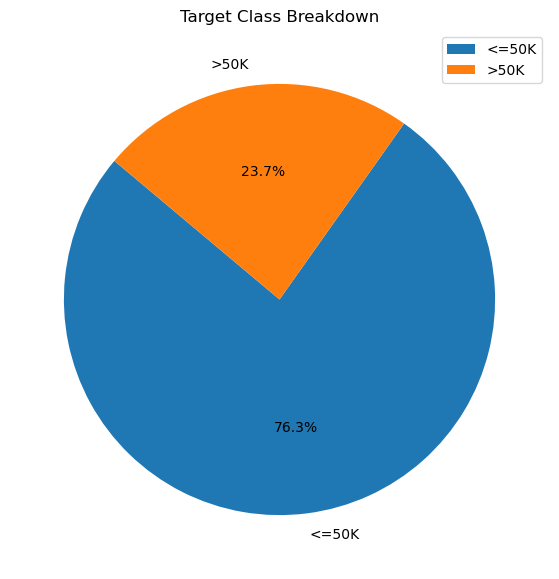

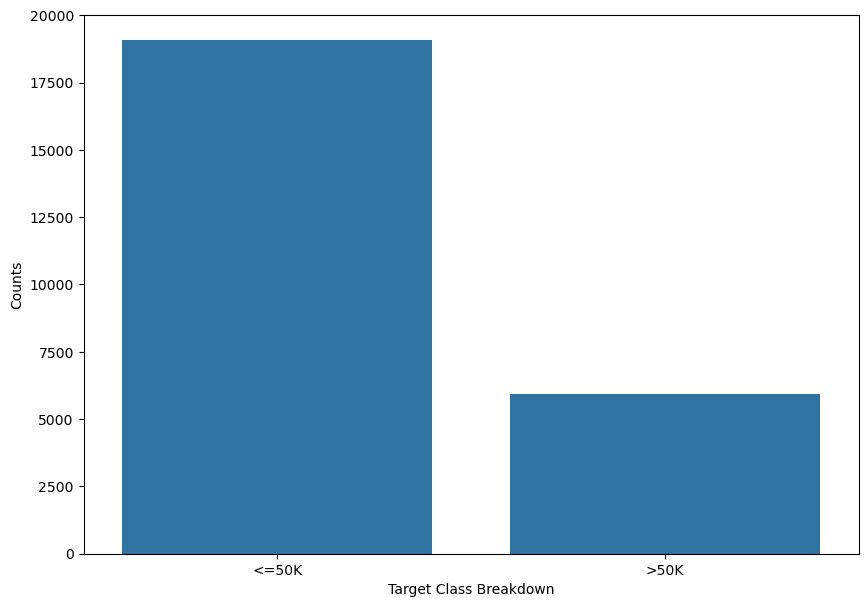

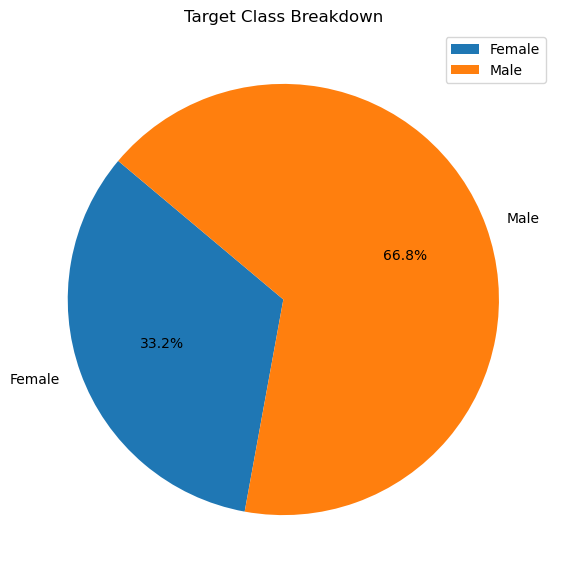

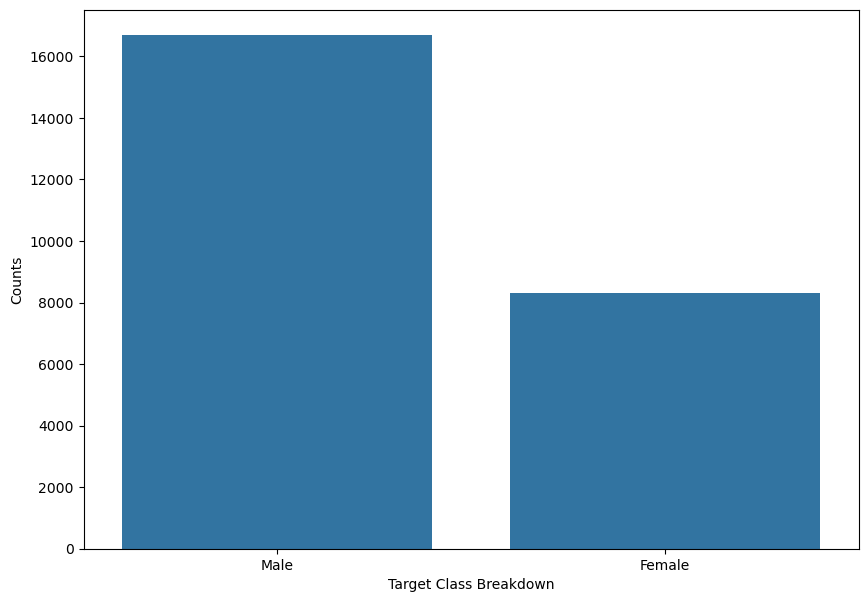

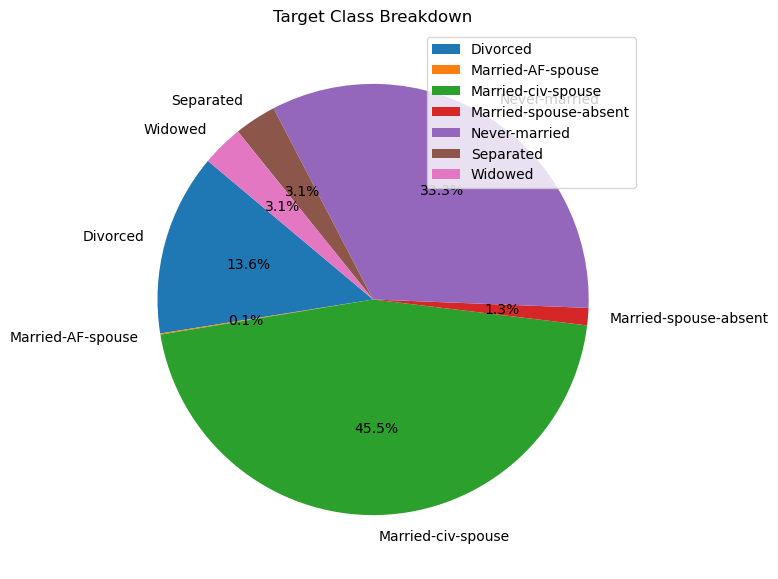

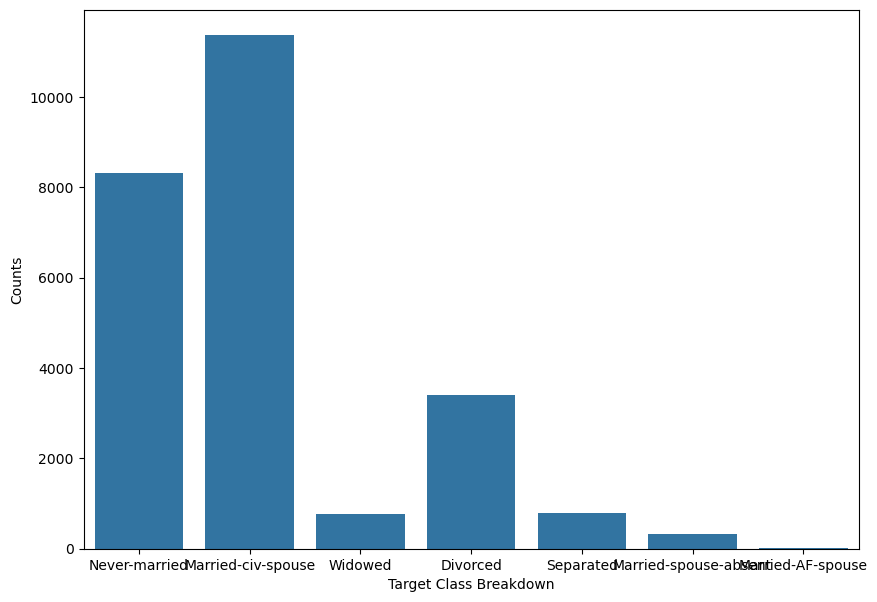

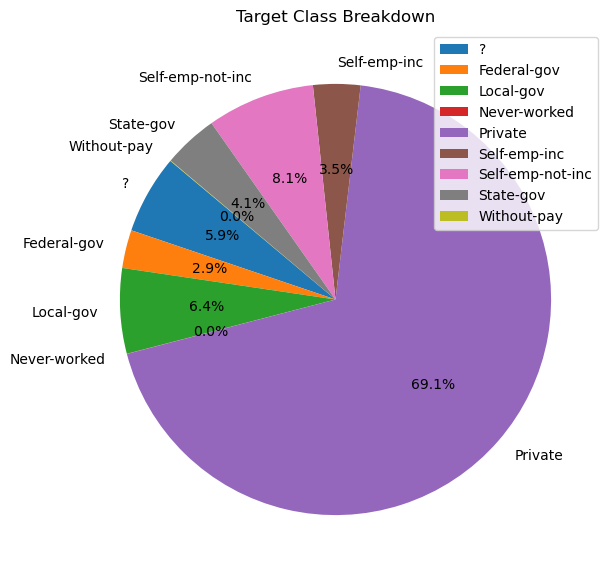

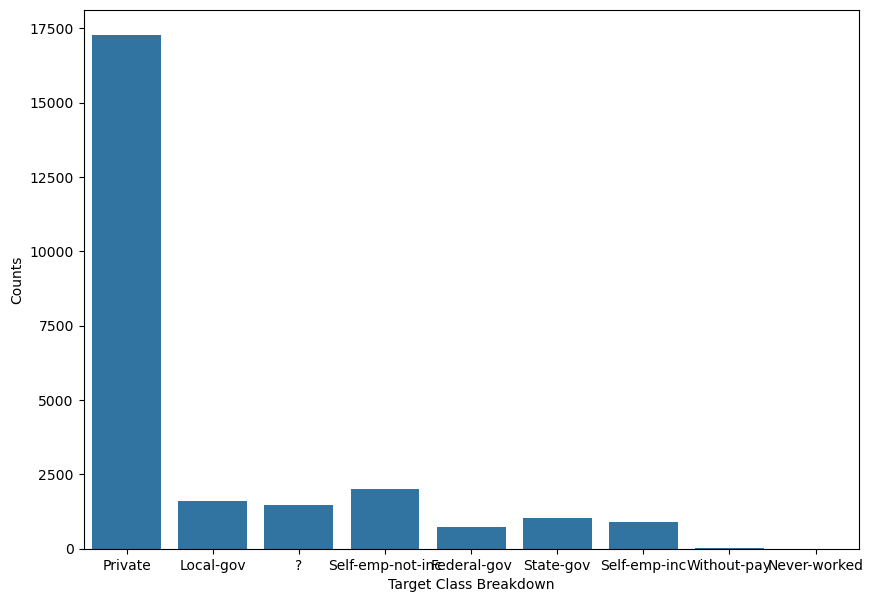

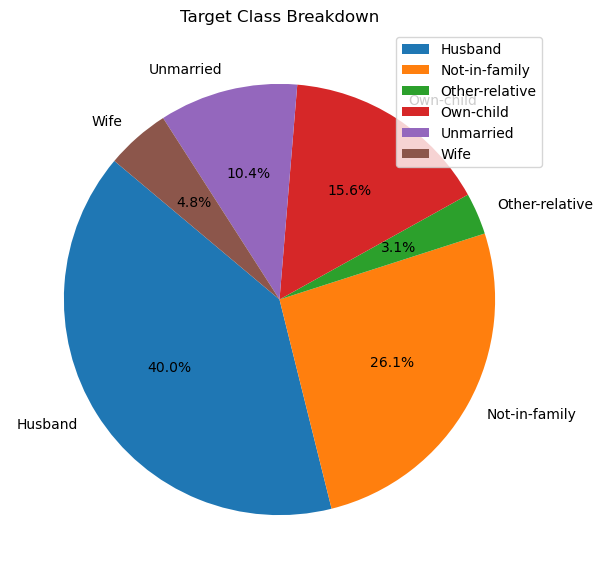

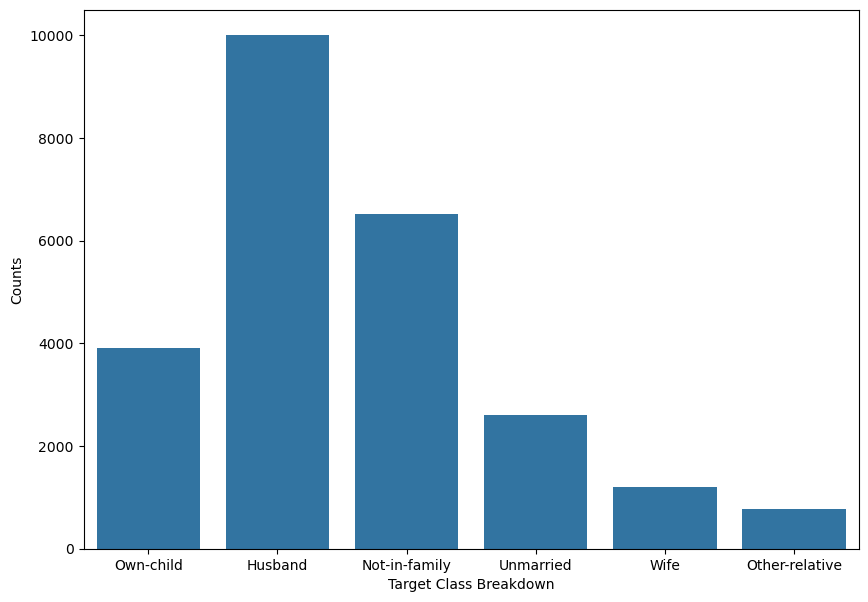

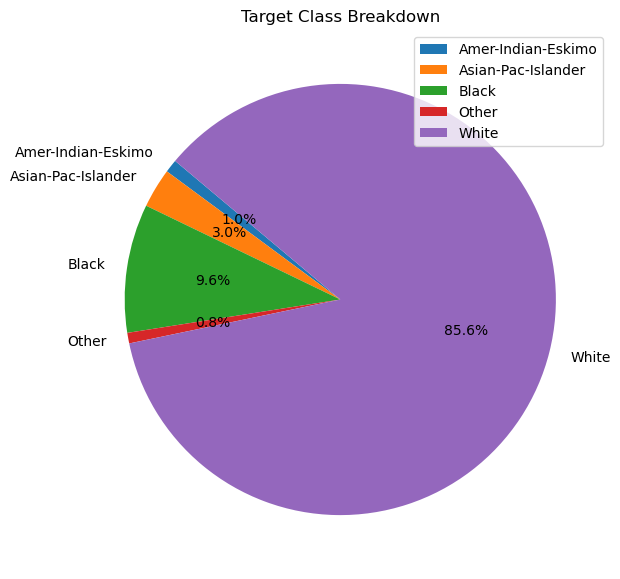

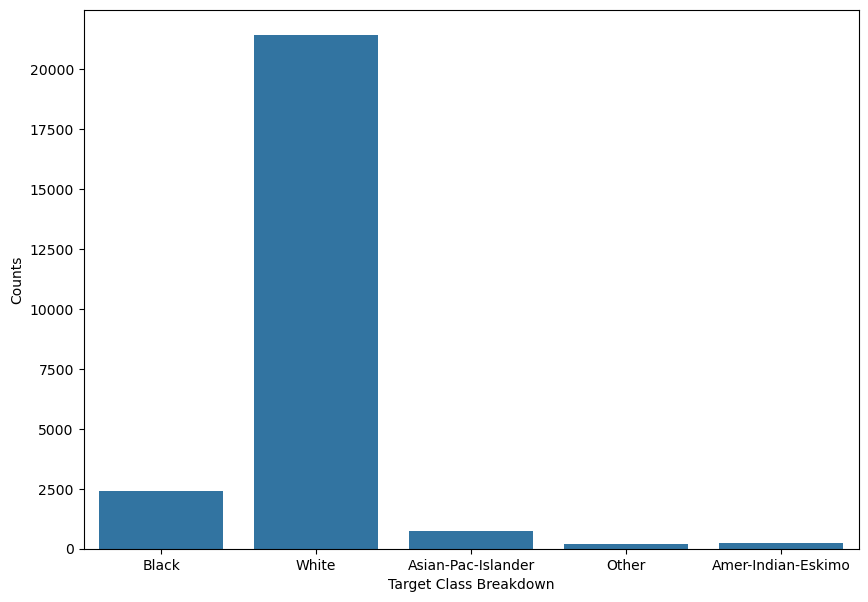

In [39]:
check_class_imbalance(df["income"])
check_class_imbalance(df["gender"])
check_class_imbalance(df["marital-status"])
check_class_imbalance(df["workclass"])
check_class_imbalance(df["relationship"])
check_class_imbalance(df["race"])

#### Data is heavily skewed to individuals with a white ethnic background

In [40]:
df.drop(["native-country", "workclass", "occupation", "race"], axis=1, inplace=True)

In [41]:
df.dtypes

age                 int64
fnlwgt              int64
education          object
educational-num     int64
marital-status     object
relationship       object
gender             object
capital-gain        int64
capital-loss        int64
hours-per-week      int64
income             object
dtype: object

In [42]:
categorical_types = df.select_dtypes(include="object")
numerical_types = df.select_dtypes(exclude="object")

# Histogram

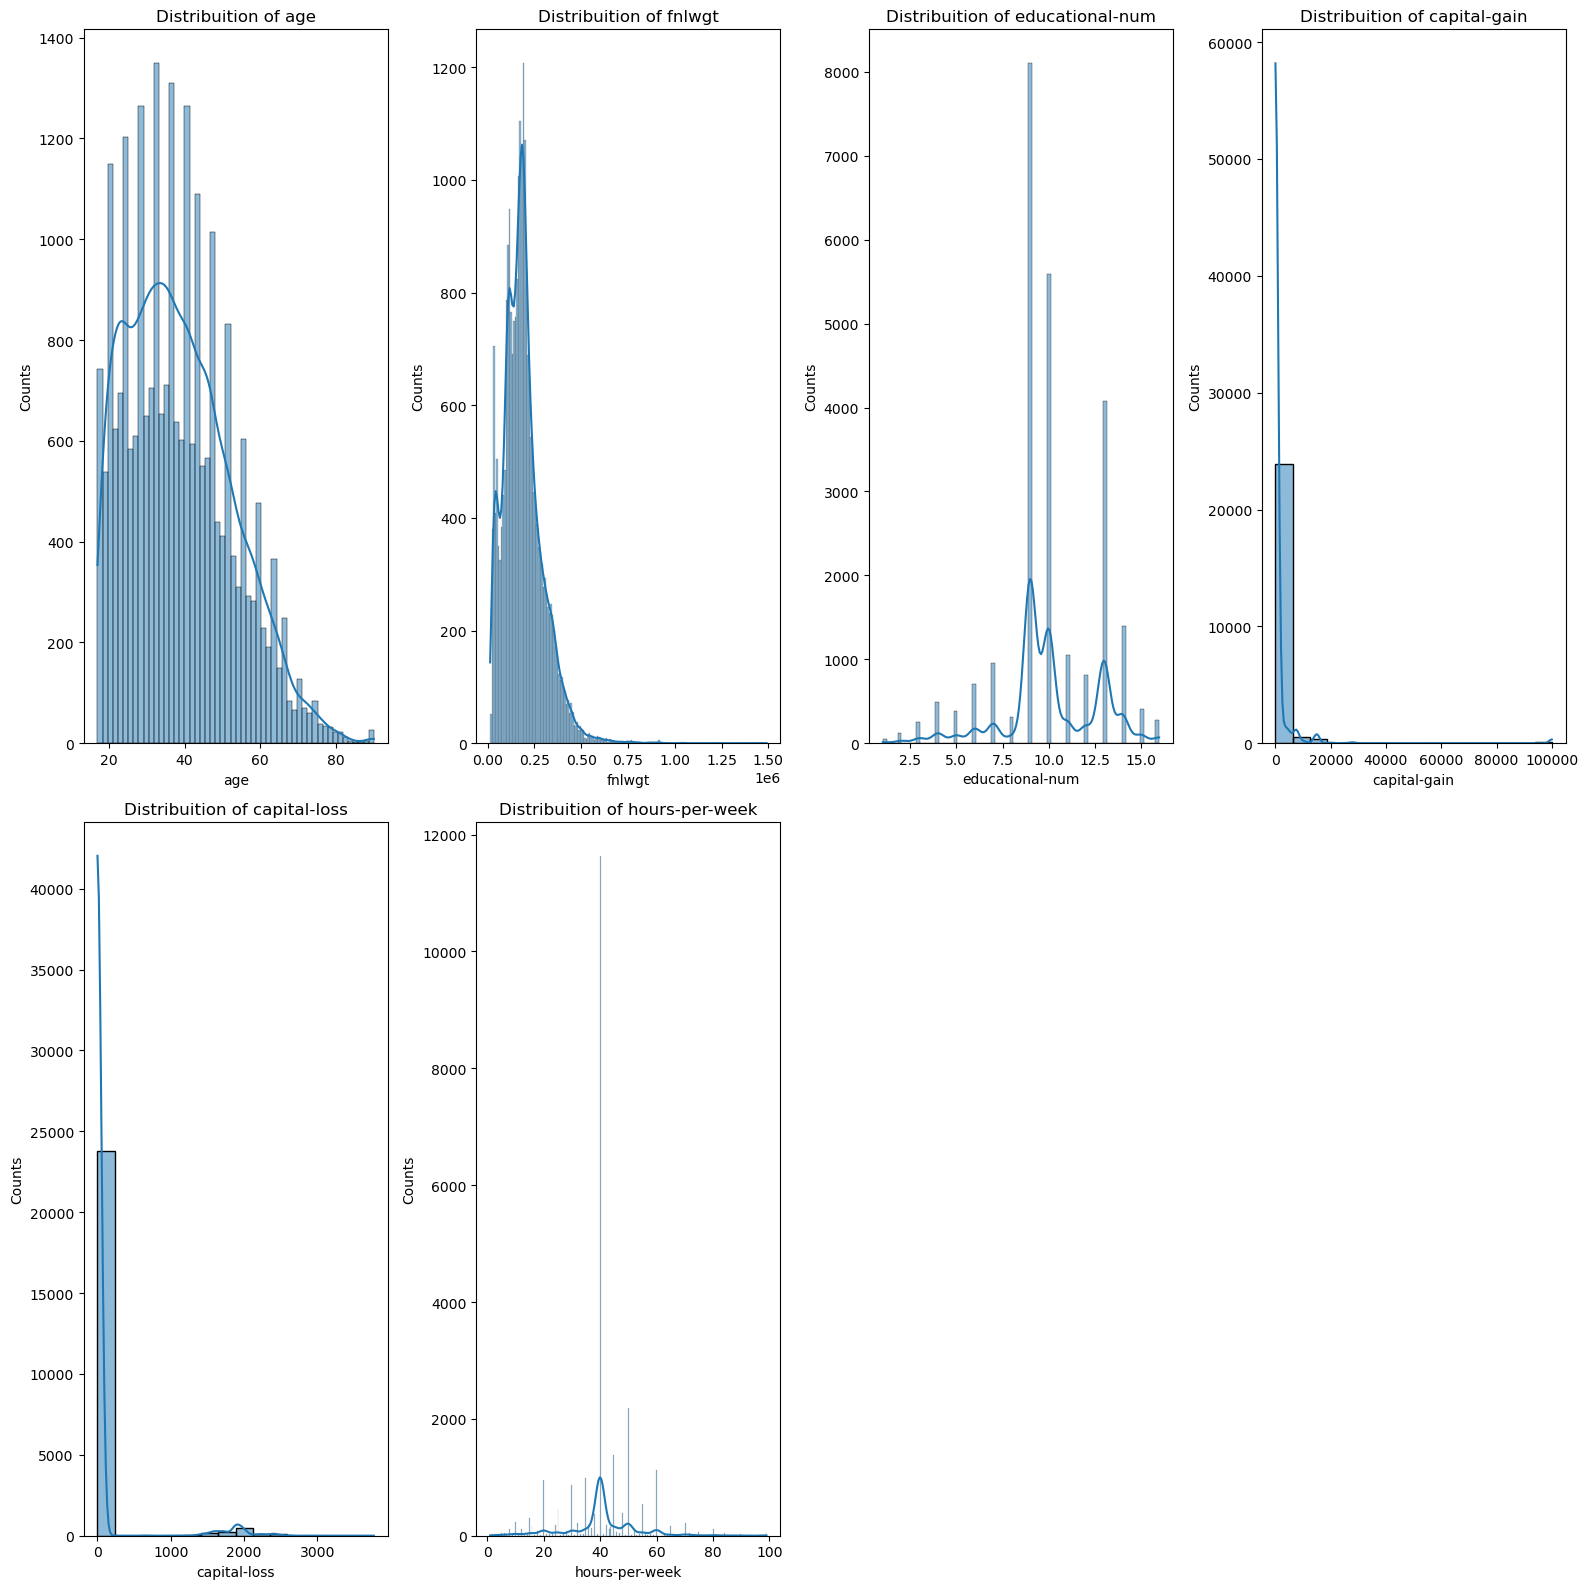

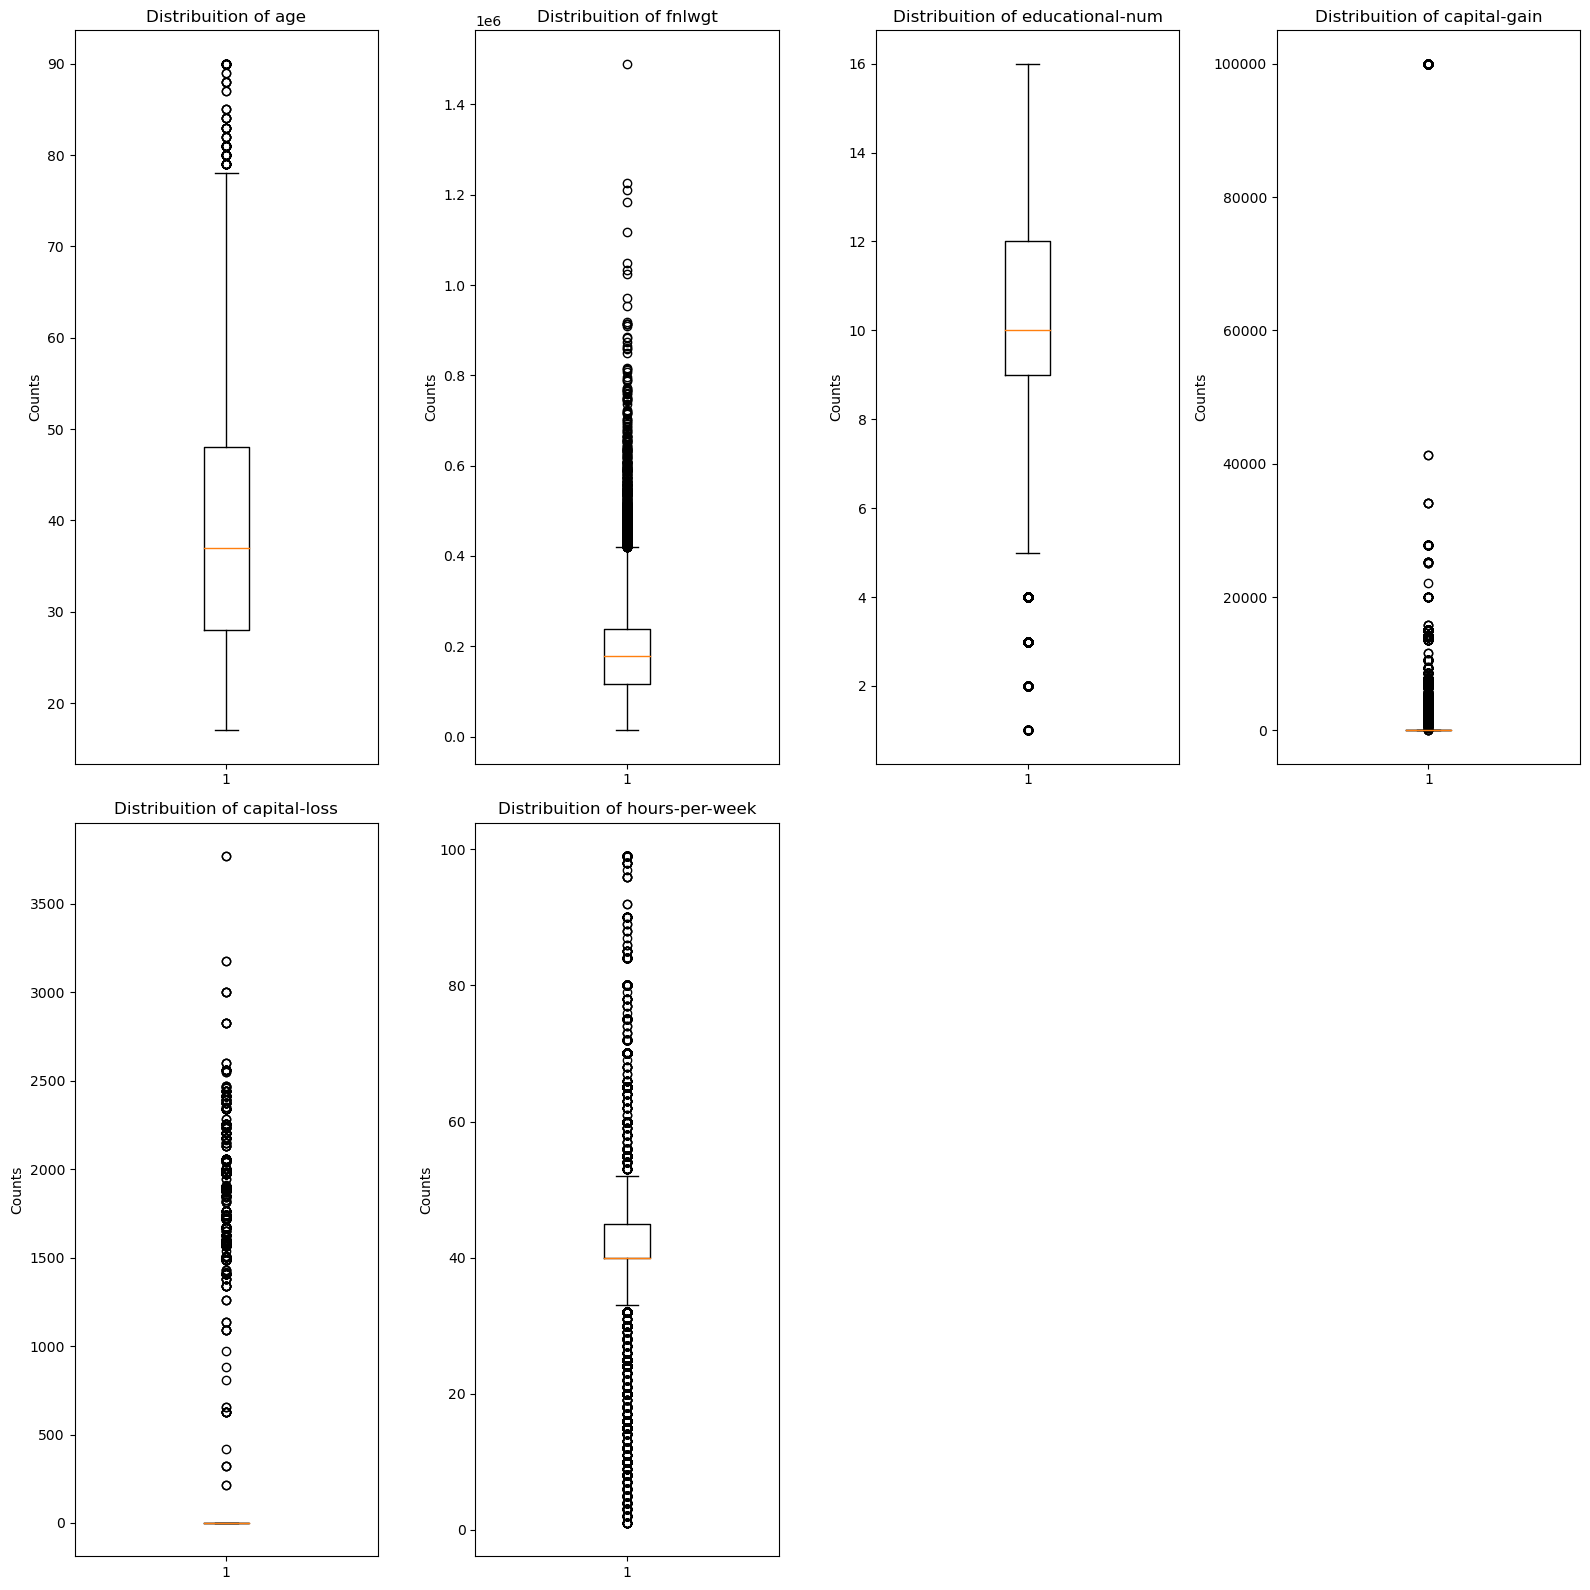

In [43]:
plot_distribution(numerical_types, "hist")
plot_distribution(numerical_types, "box")

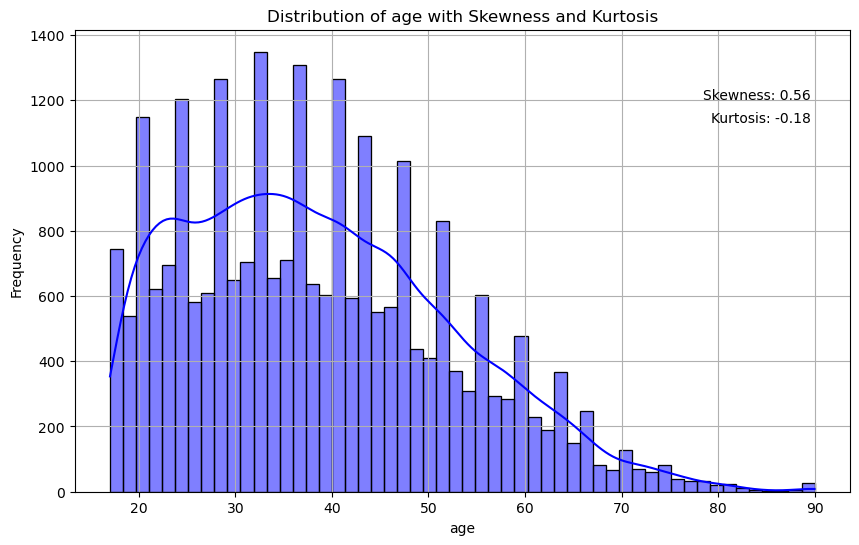

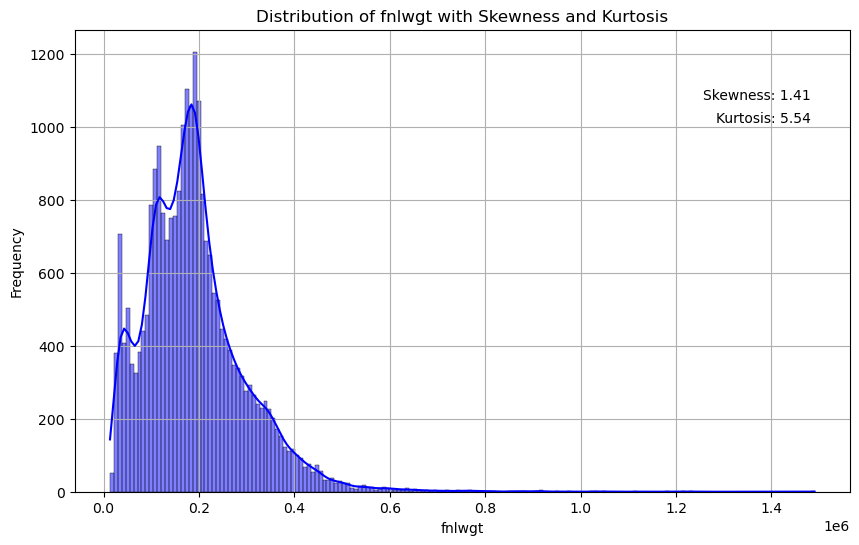

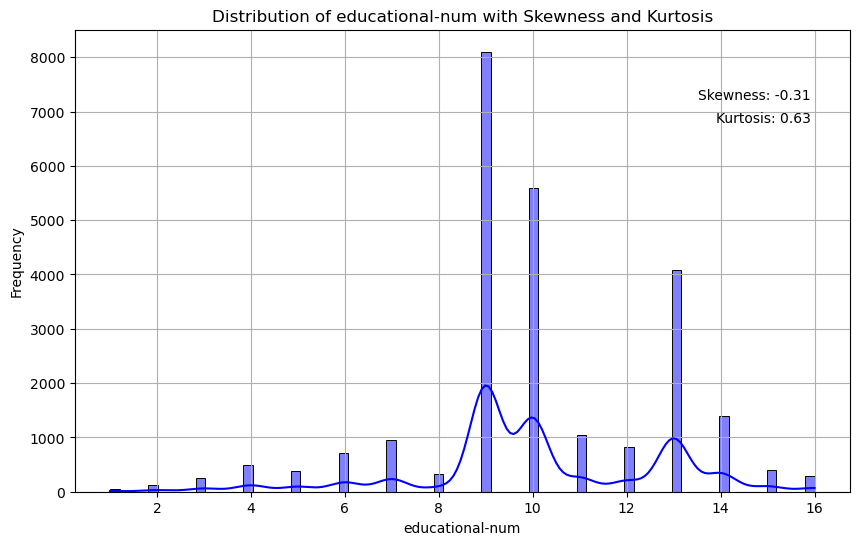

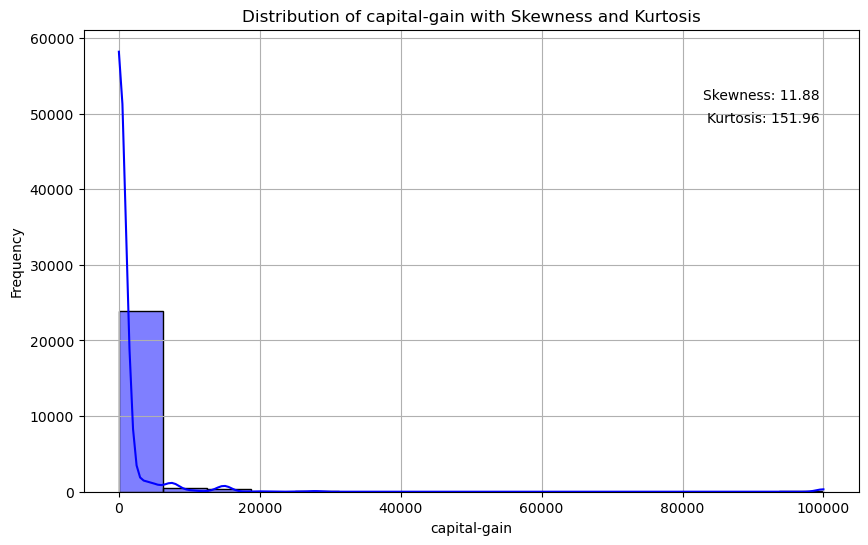

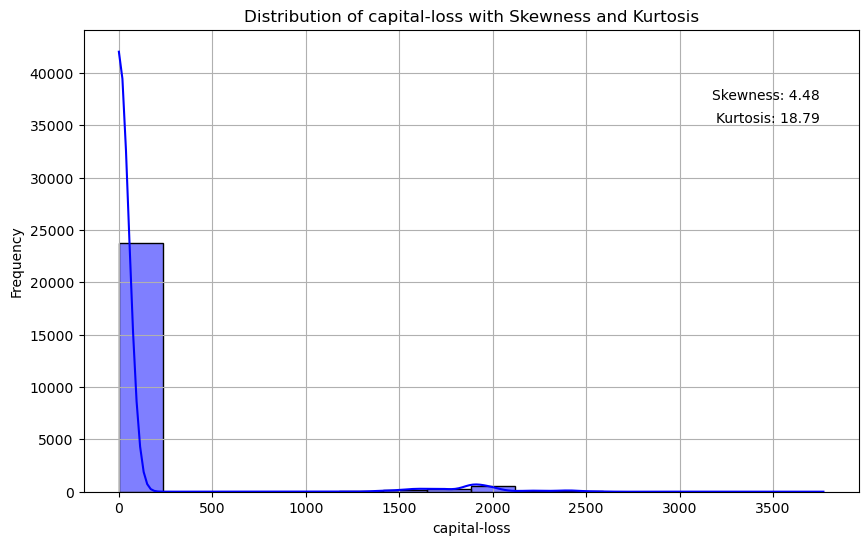

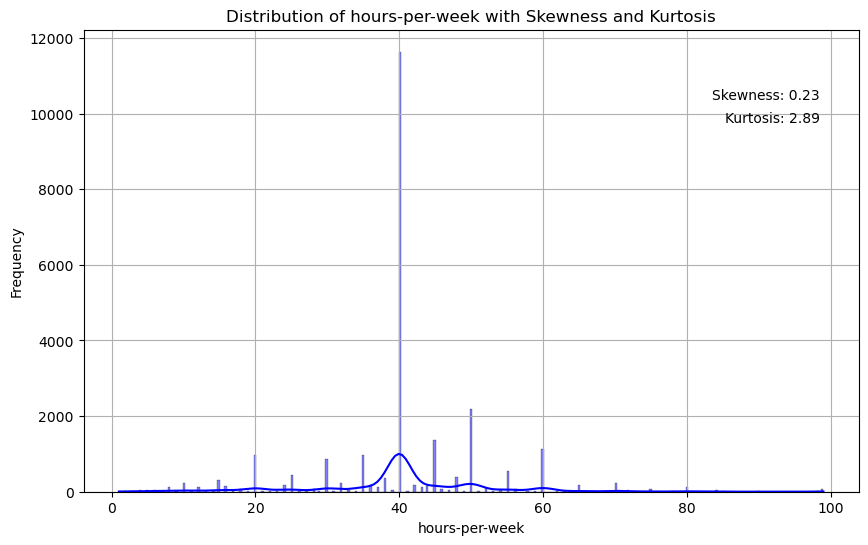

In [44]:
dist_plot(numerical_types)

# Aggregations

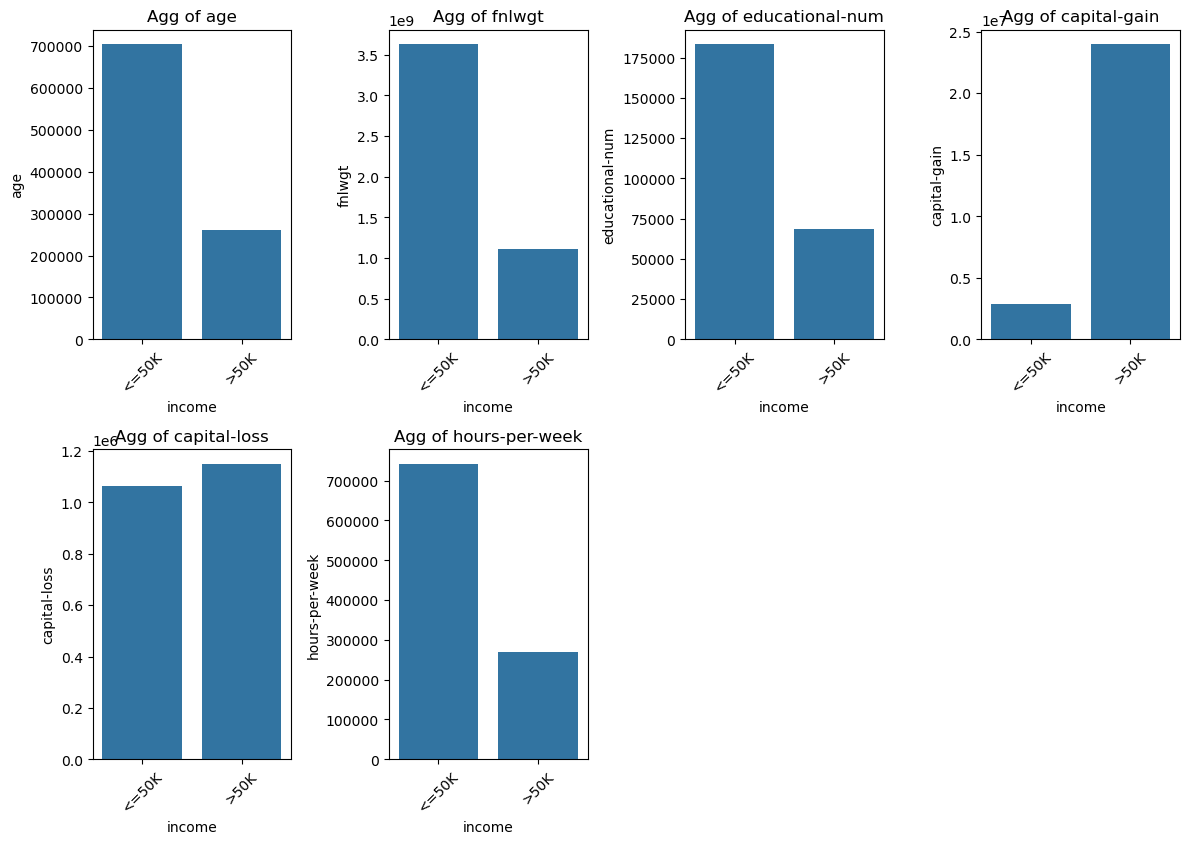

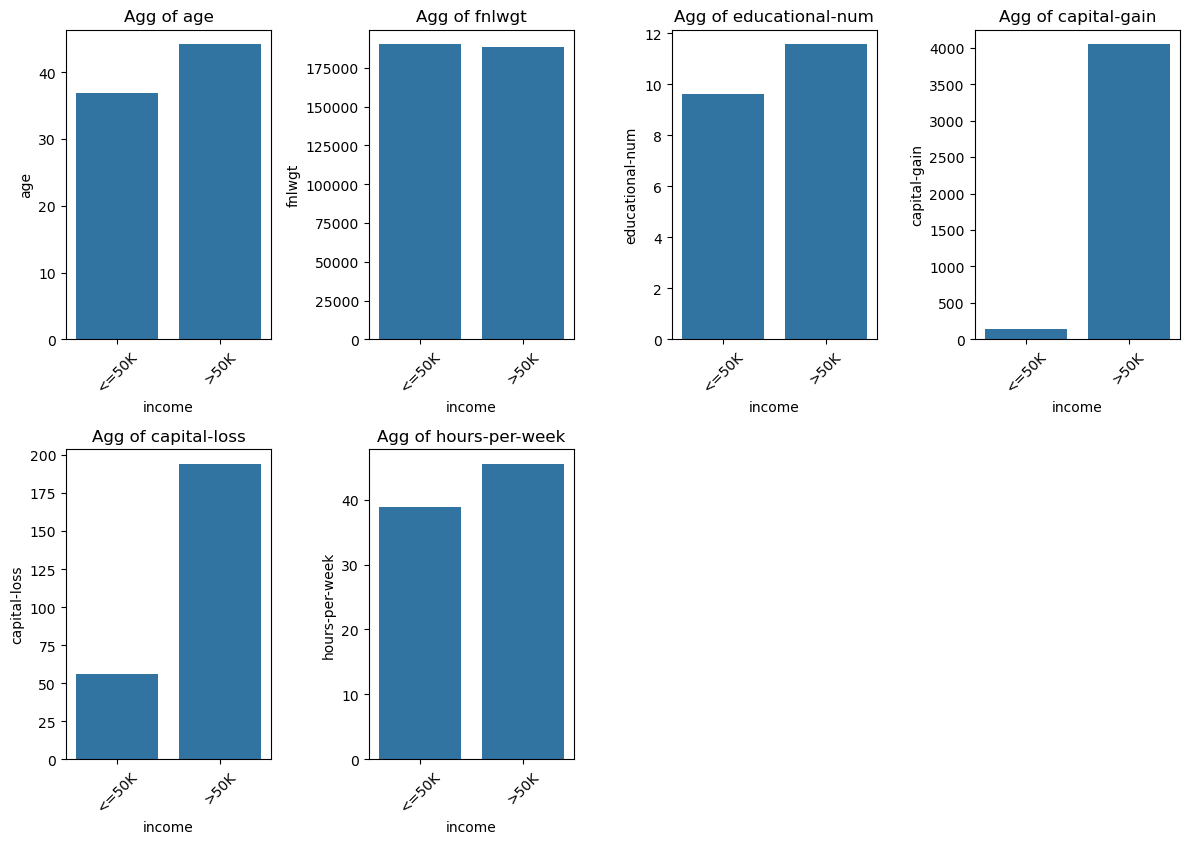

In [45]:
aggregate_dataset(df, numerical_types.columns, "income", "sum")
aggregate_dataset(df, numerical_types.columns, "income", "mean")

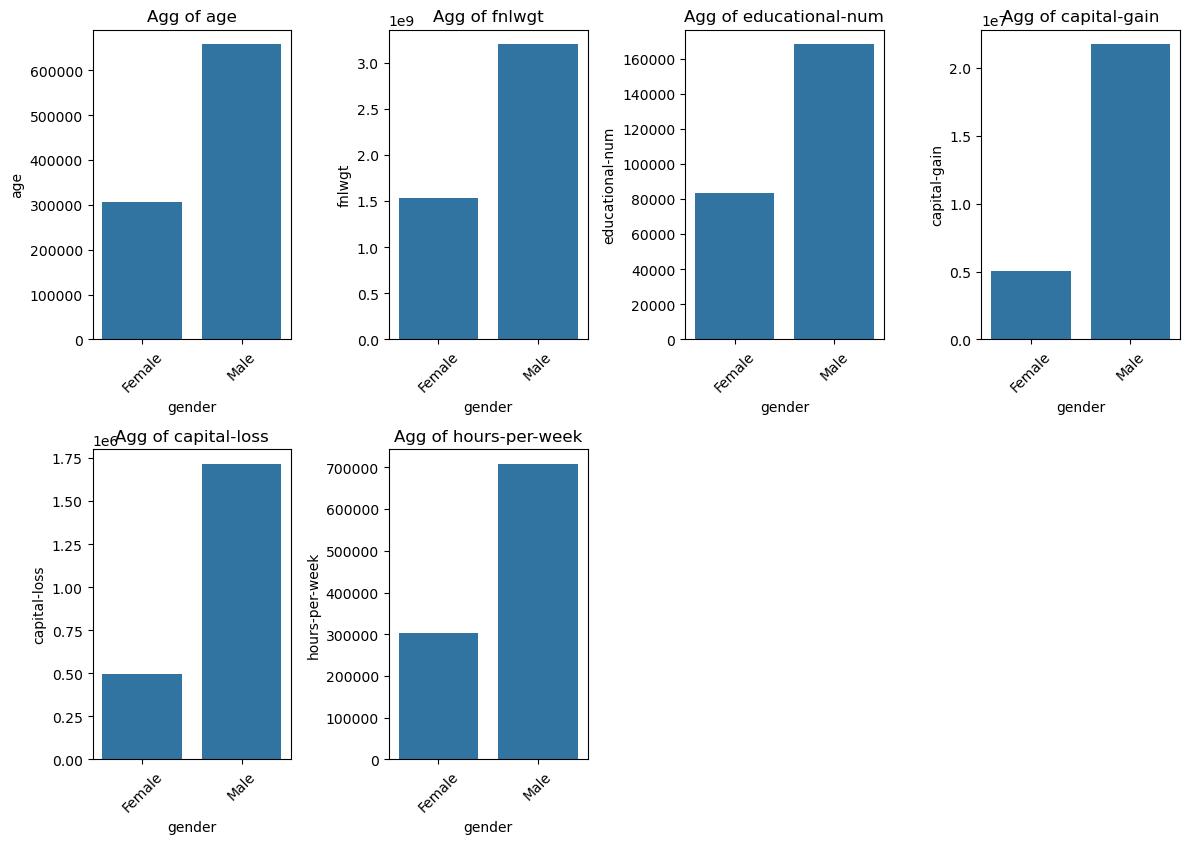

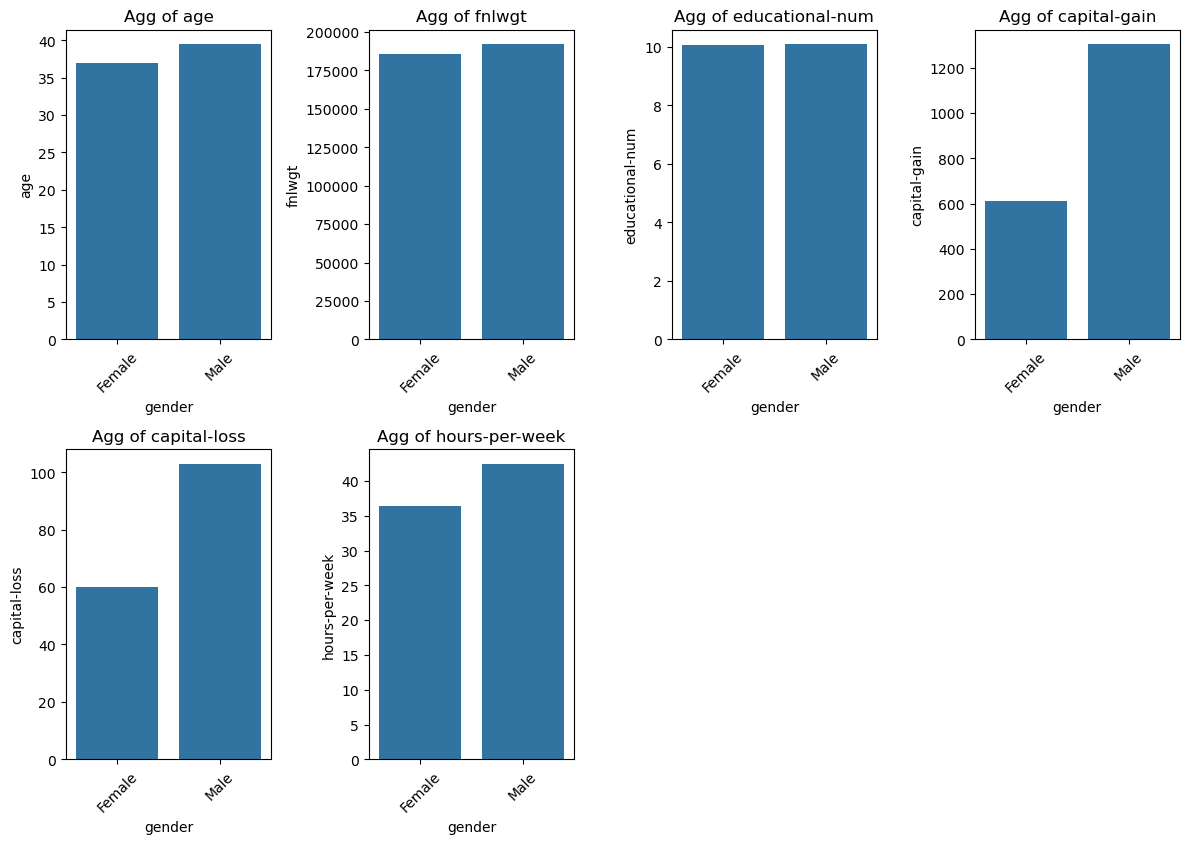

In [46]:
aggregate_dataset(df, numerical_types.columns, "gender", "sum")
aggregate_dataset(df, numerical_types.columns, "gender", "mean")

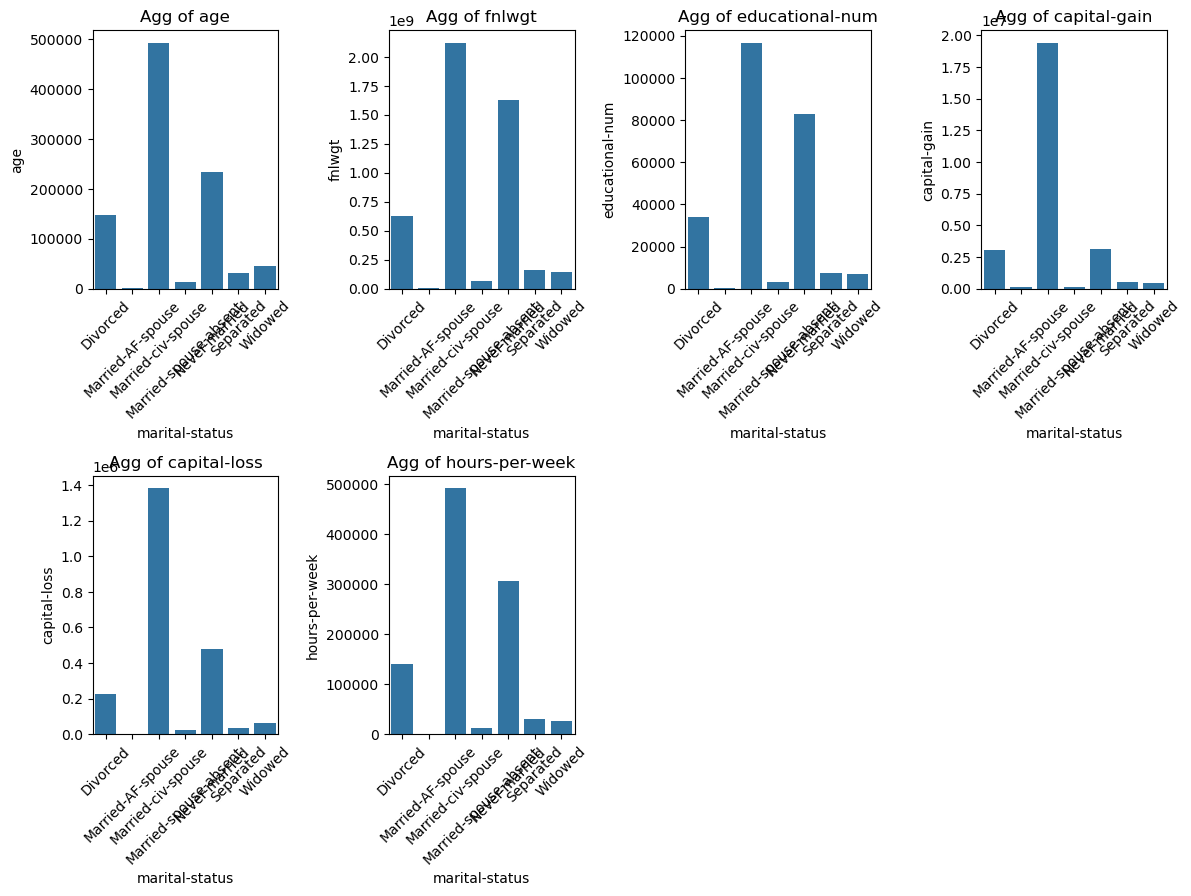

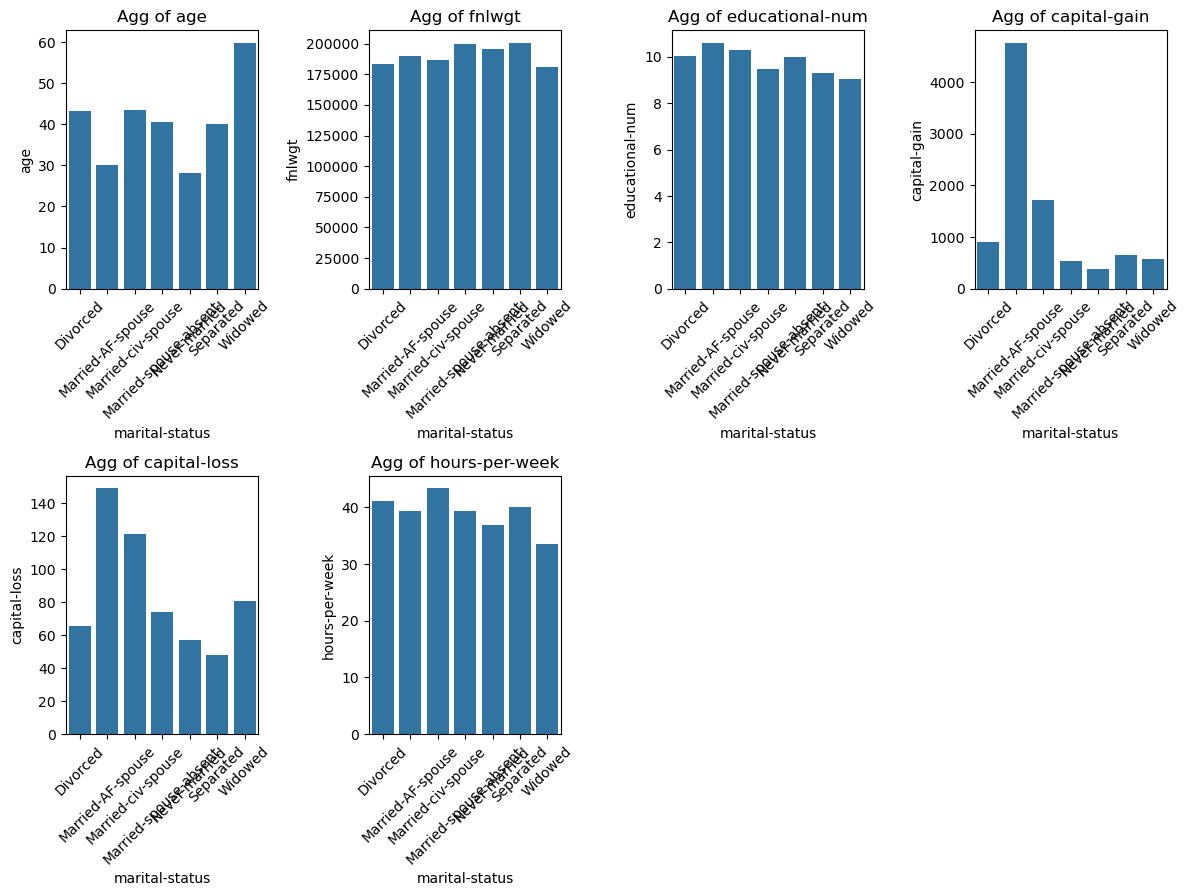

In [47]:
aggregate_dataset(df, numerical_types.columns, "marital-status", "sum")
aggregate_dataset(df, numerical_types.columns, "marital-status", "mean")

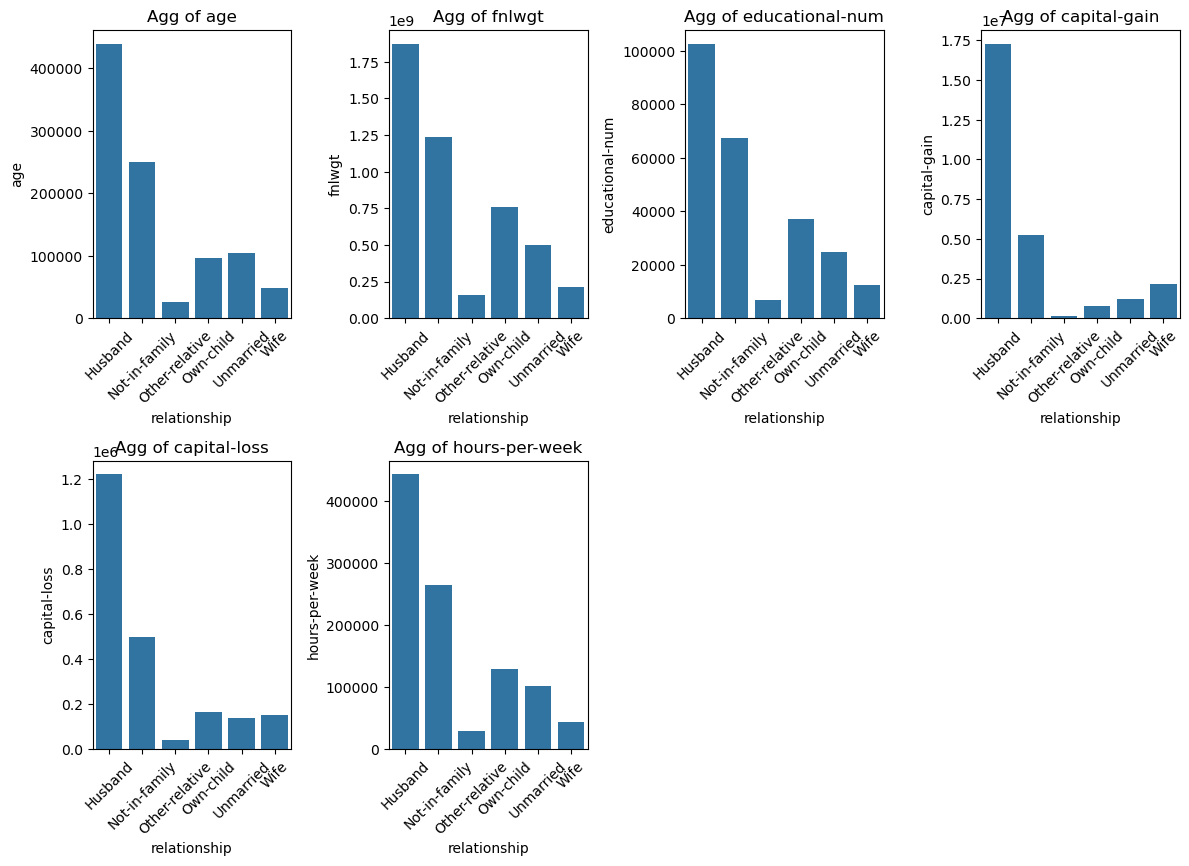

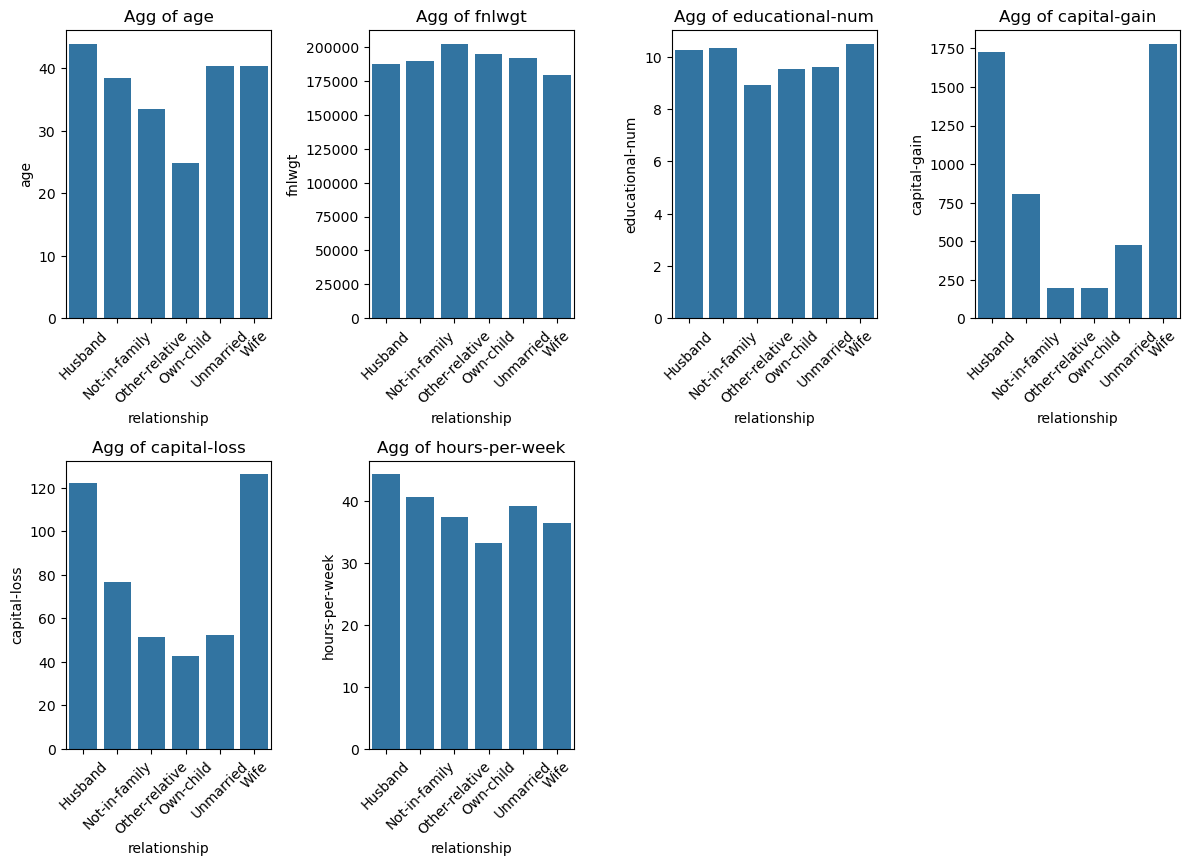

In [48]:
aggregate_dataset(df, numerical_types.columns, "relationship", "sum")
aggregate_dataset(df, numerical_types.columns, "relationship", "mean")

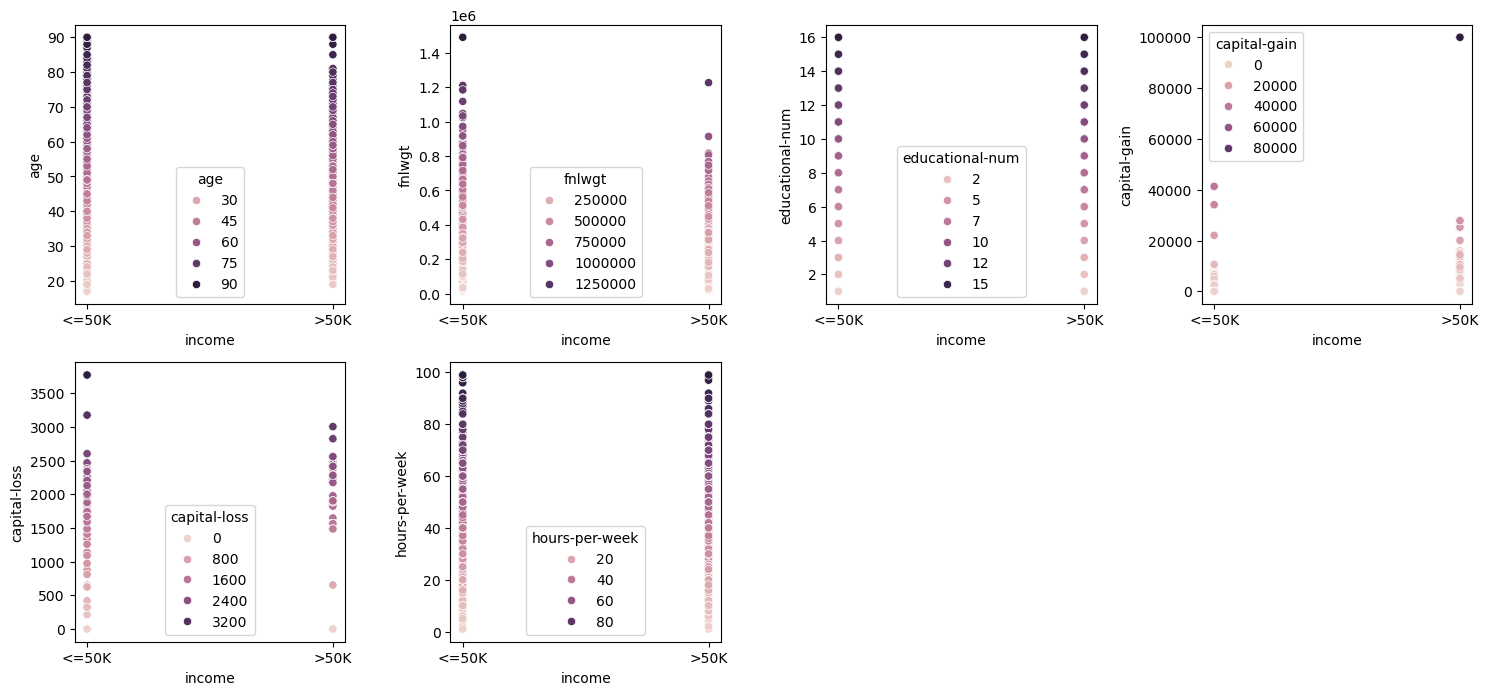

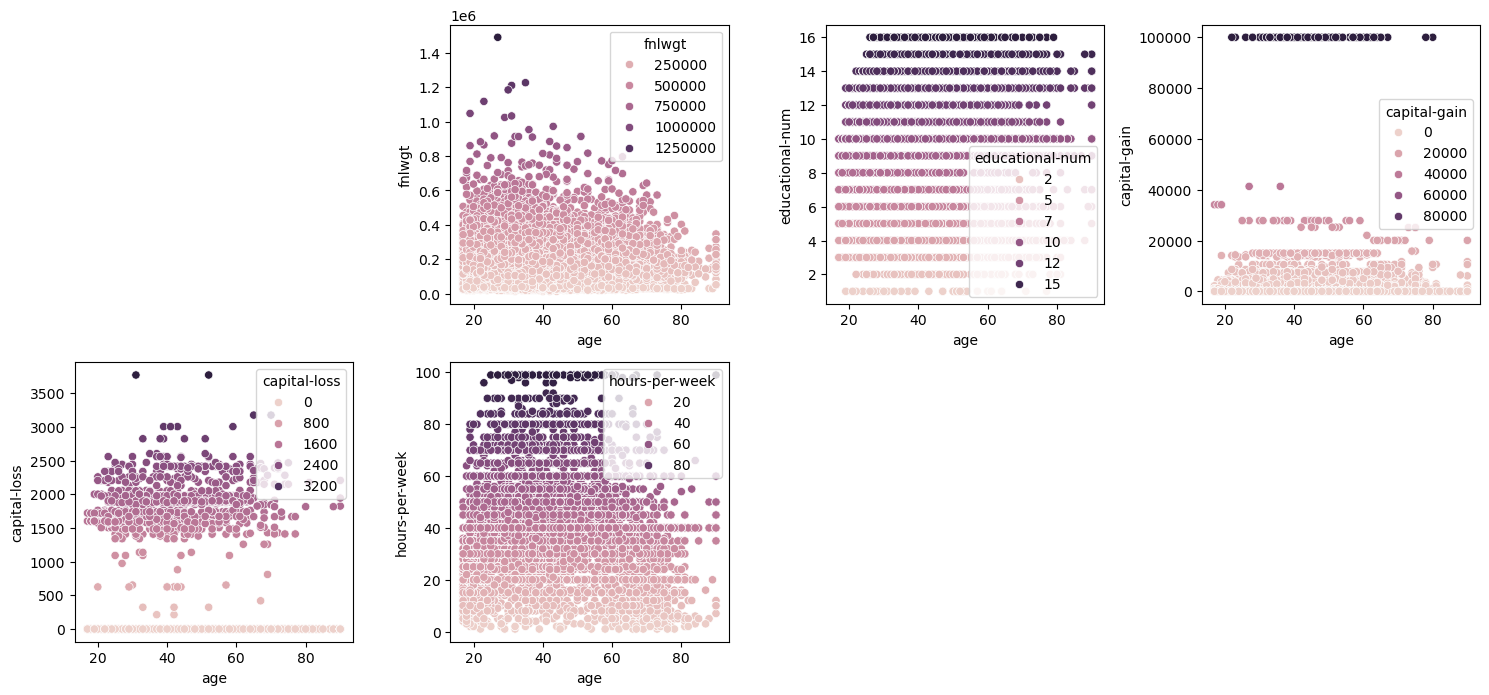

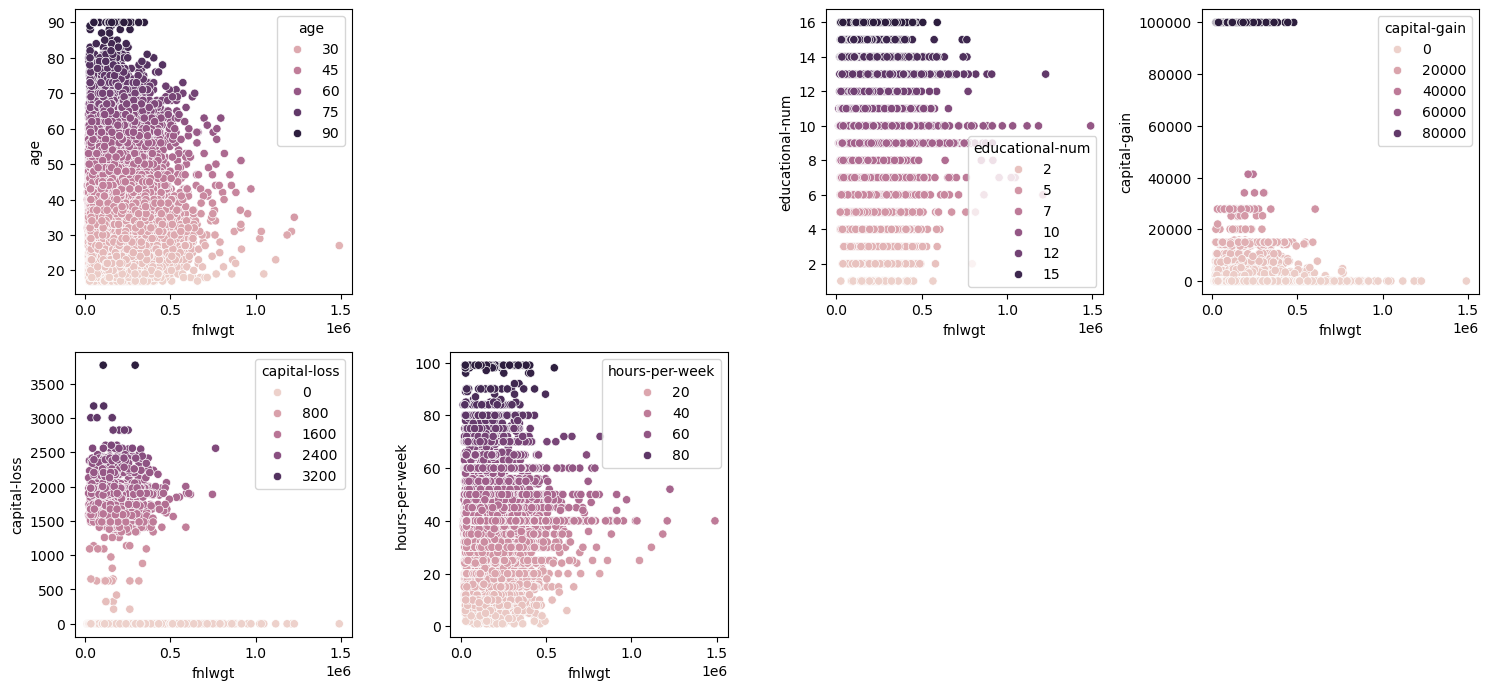

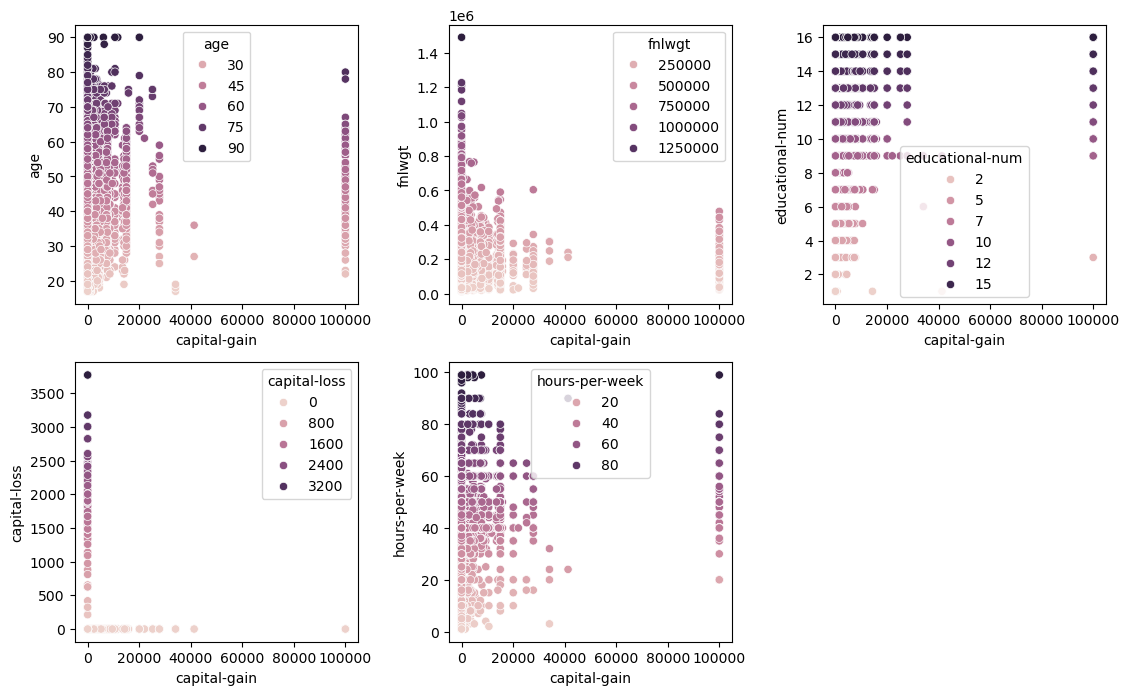

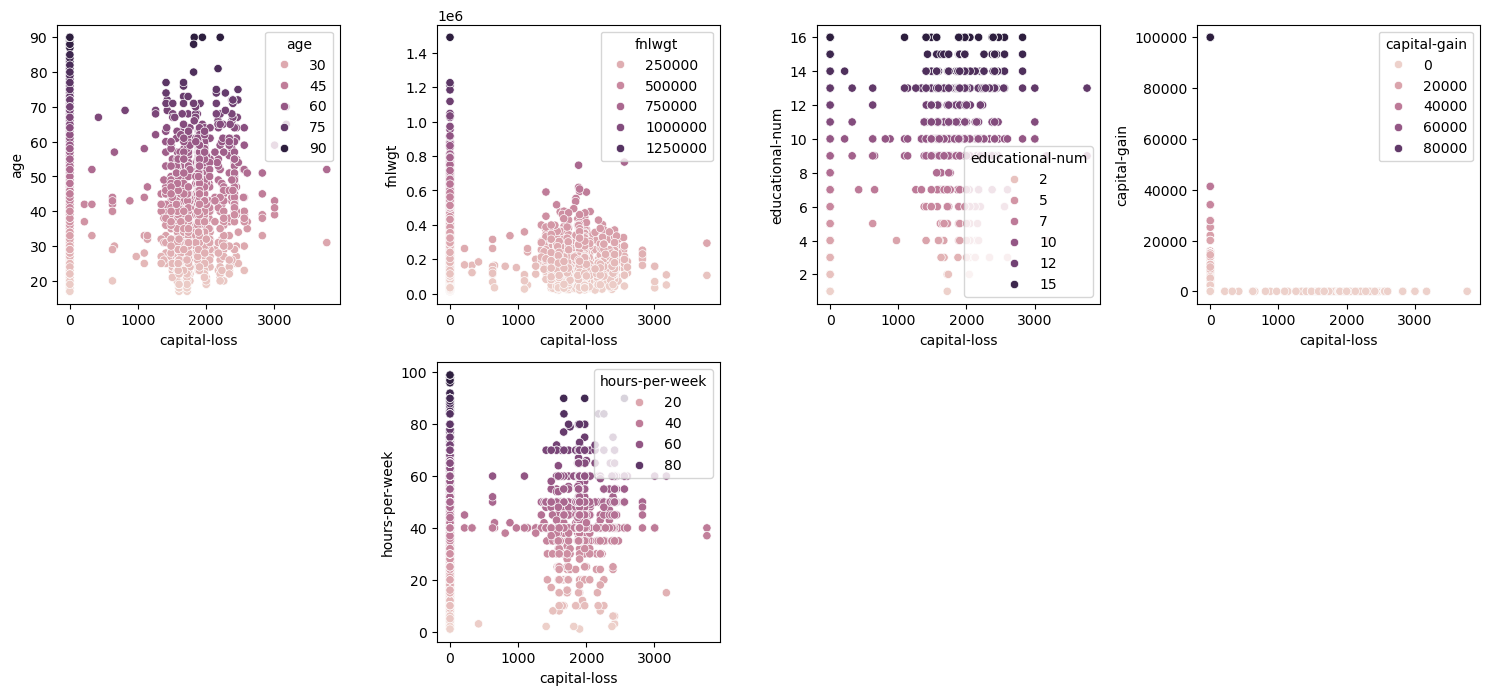

In [49]:
scatter_plot(df, numerical_types.columns, "income")
scatter_plot(df, numerical_types.columns, "age")
scatter_plot(df, numerical_types.columns, "fnlwgt")
scatter_plot(df, numerical_types.columns, "capital-gain")
scatter_plot(df, numerical_types.columns, "capital-loss")

# Heatmap

<AxesSubplot:>

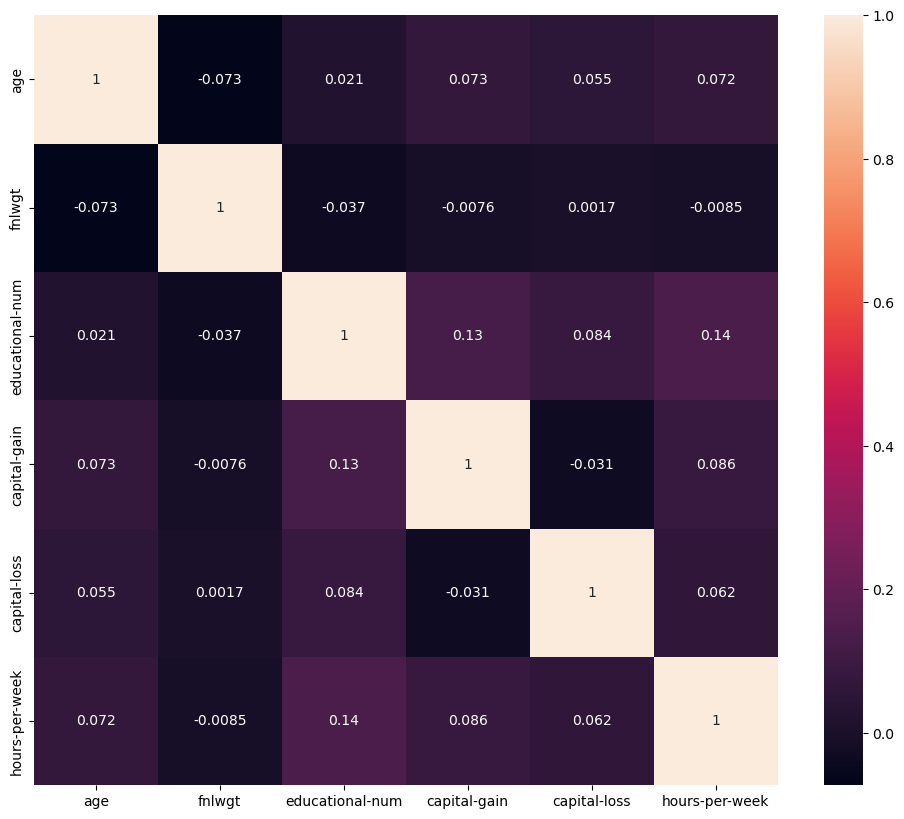

In [50]:
relations = numerical_types.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(data=relations, annot=True)

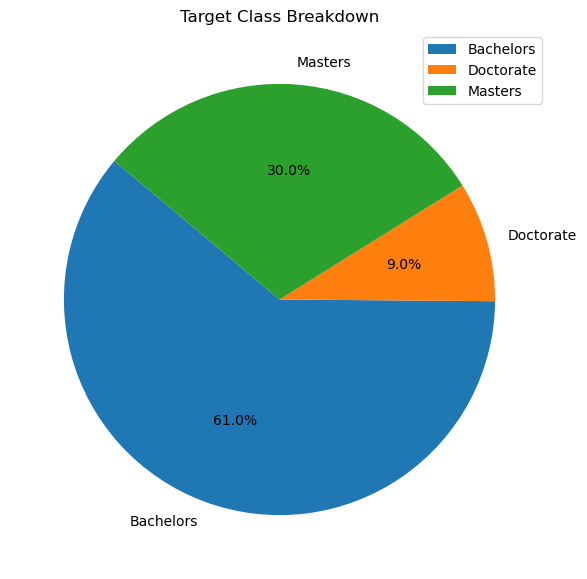

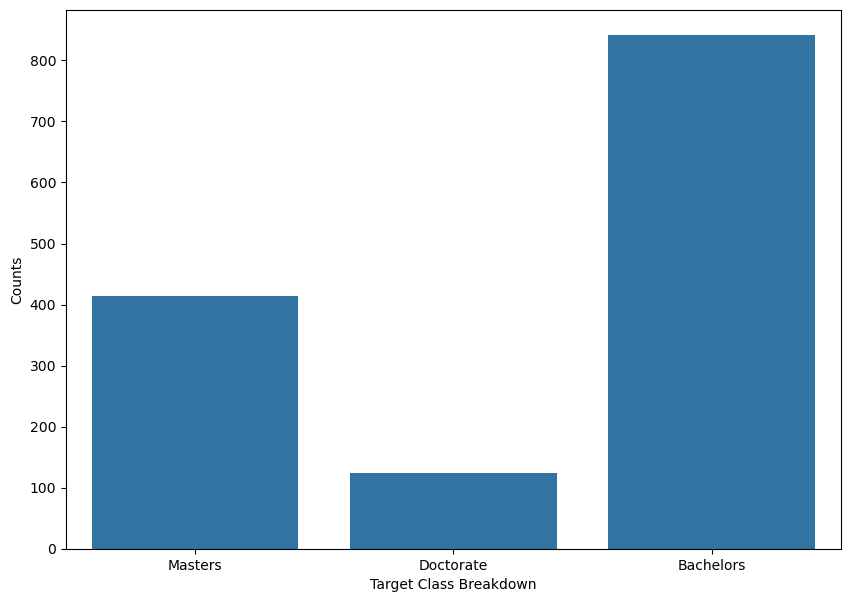

In [51]:
long_hours_high_earners = df[(df["income"] == ">50K") & (df["hours-per-week"] > 40) & (df["education"].isin(["Masters", "Doctorate", "Bachelors"]))]
check_class_imbalance(long_hours_high_earners["education"])

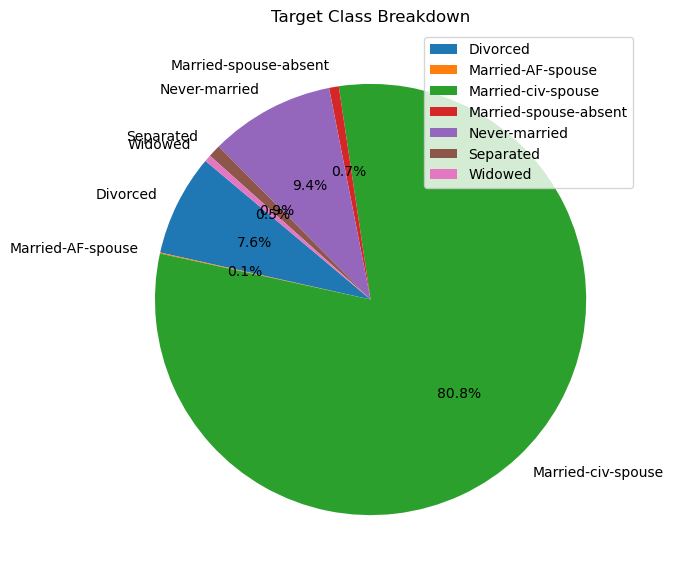

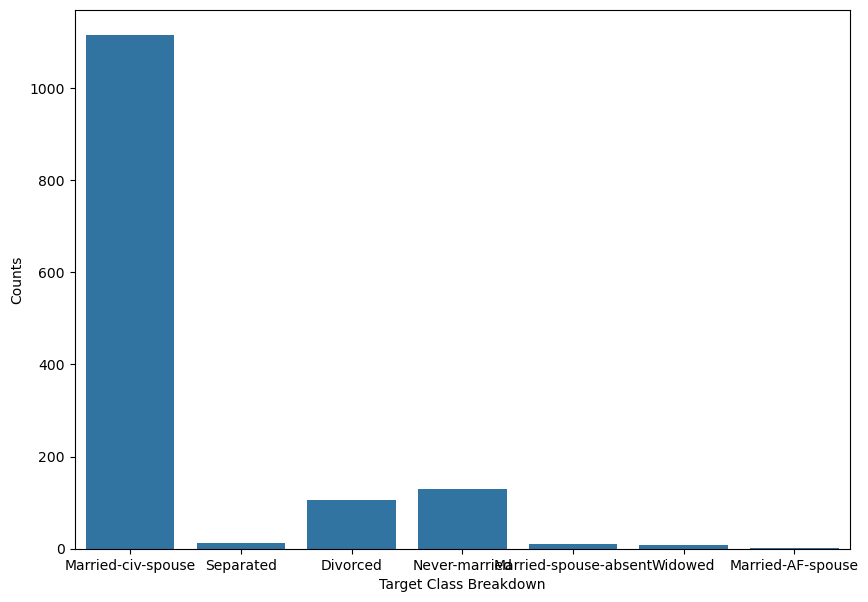

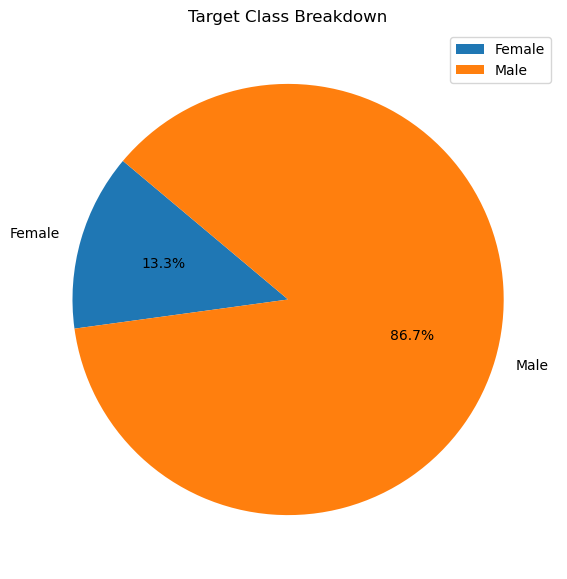

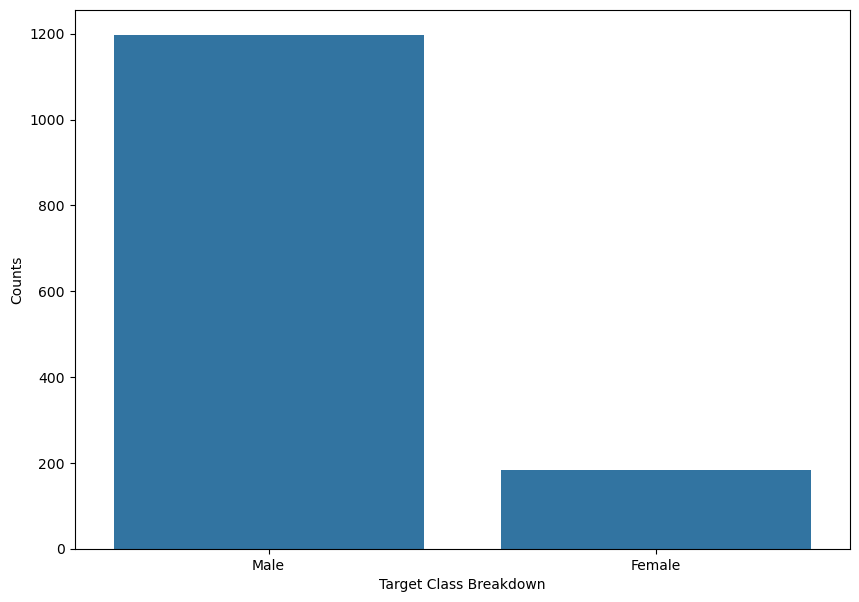

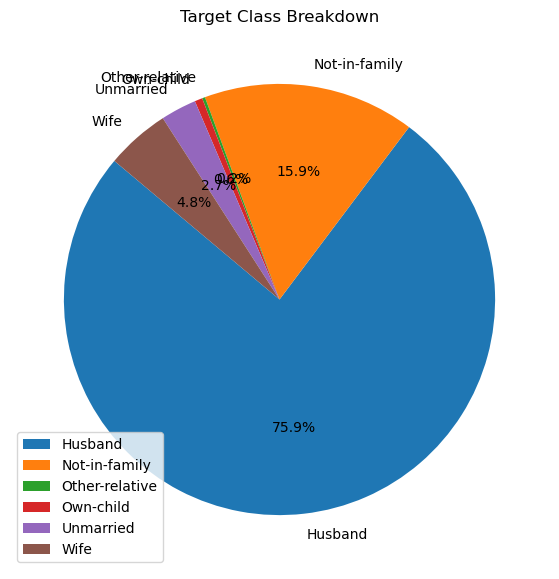

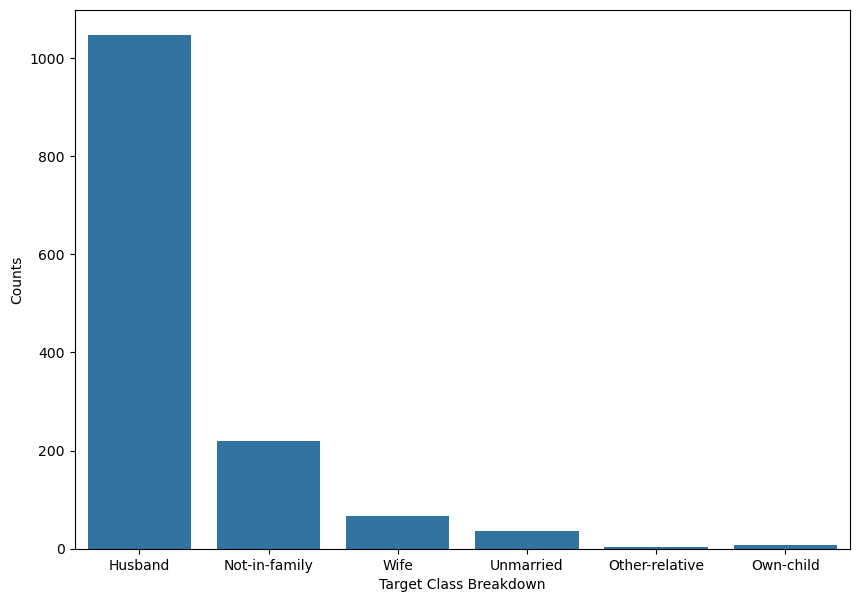

In [52]:
check_class_imbalance(long_hours_high_earners["marital-status"])
check_class_imbalance(long_hours_high_earners["gender"])
check_class_imbalance(long_hours_high_earners["relationship"])

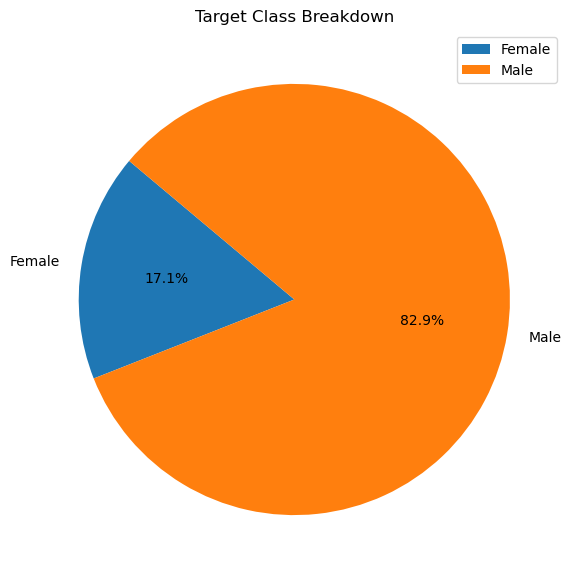

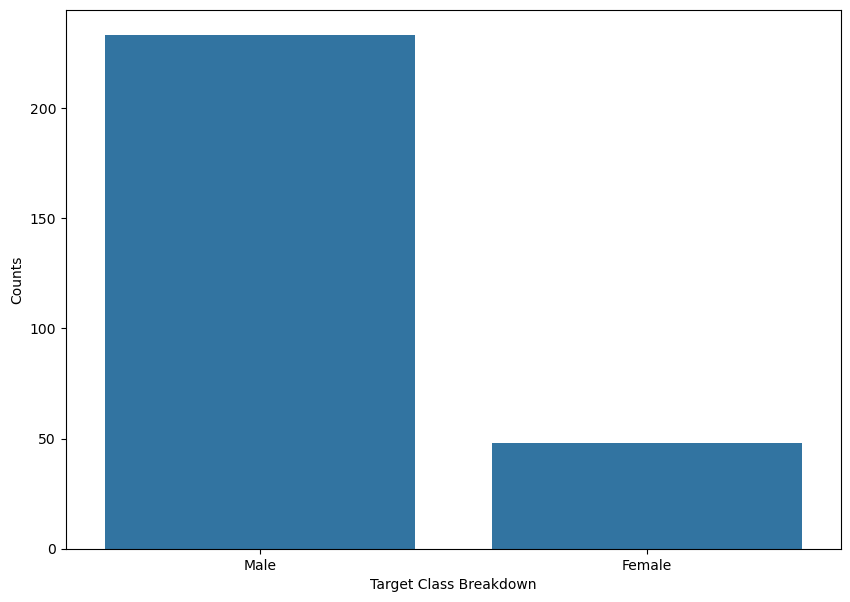

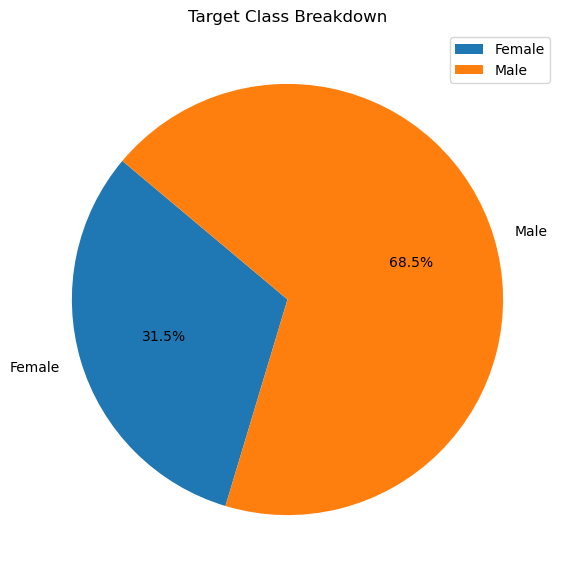

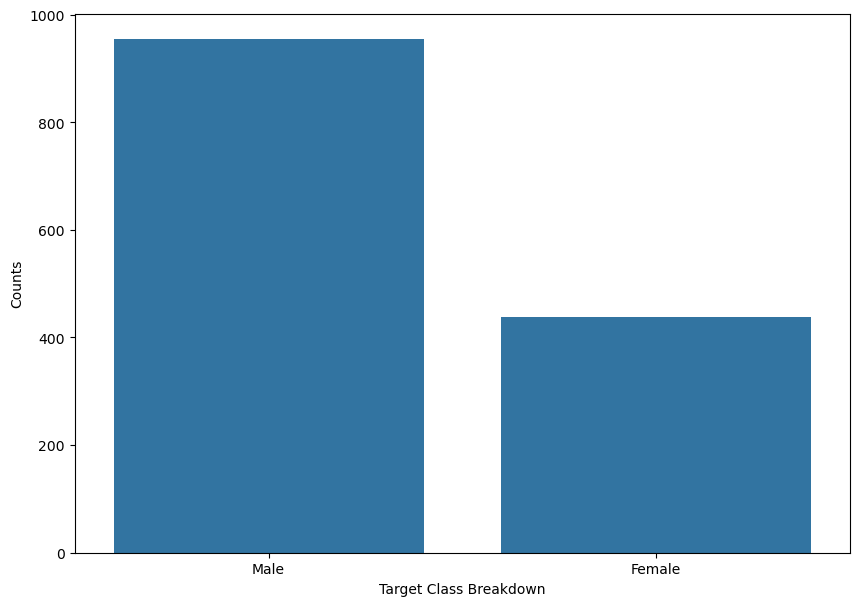

In [53]:
doctorate = df[df["education"] == "Doctorate"]
masters = df[df["education"] == "Masters"]
check_class_imbalance(doctorate["gender"])
check_class_imbalance(masters["gender"])

# Create Preprocessor

In [54]:
categorical_types.drop(["education", "income"], axis=1, inplace=True)

In [55]:
preprocessor = create_column_transformer(categorical_types.columns, numerical_types.columns)
preprocessor

ColumnTransformer(transformers=[('cat',
                                 Pipeline(steps=[('encoder', OneHotEncoder())]),
                                 Index(['marital-status', 'relationship', 'gender'], dtype='object')),
                                ('numeric',
                                 Pipeline(steps=[('scaler', StandardScaler()),
                                                 ('PowerTransformer',
                                                  PowerTransformer())]),
                                 Index(['age', 'fnlwgt', 'educational-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object'))])

# Separate Features

In [56]:
X = df.drop("income", axis=1)
y = df["income"]

encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# PCA Analysis

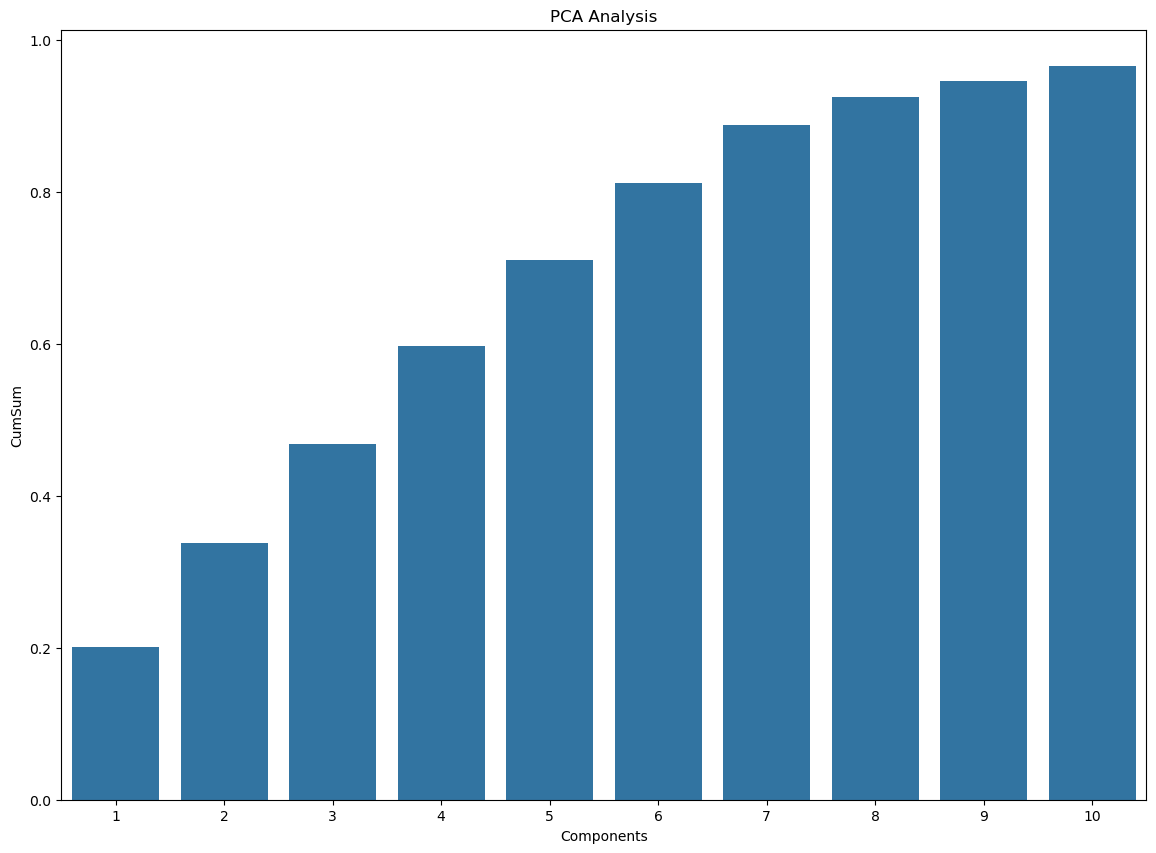

Component    CumSum
0          1  0.200872
1          2  0.337235
2          3  0.468672
3          4  0.596633
4          5  0.710004
5          6  0.810946
6          7  0.887931
7          8  0.925252
8          9  0.945621
9         10  0.964877

In [57]:
pca_analysis(X, preprocessor)

# Baseline Model

In [58]:
acc_metric = make_scorer(accuracy_score, greater_is_better=True)
f1_metric = make_scorer(f1_score, greater_is_better=True, average="weighted")
precision_metric = make_scorer(precision_score, greater_is_better=True, average='weighted')
recall_metric = make_scorer(recall_score, greater_is_better=True, average='weighted')

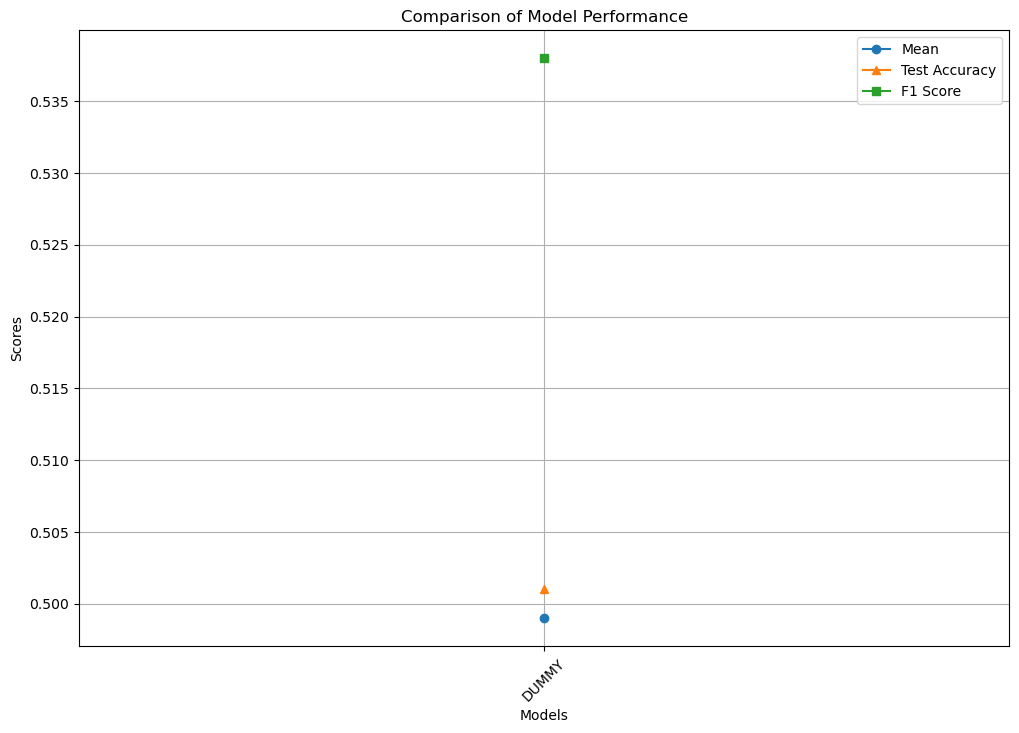

Model   Mean  Var    STD  Test-Acc  recall-Score  precision-Score  F1-Score
0  DUMMY  0.499  0.0  0.009     0.501         0.501             0.64     0.538

In [59]:
model_name = ["DUMMY"]
models = grab_selected_models(model_name)
test_selected_models(preprocessor,model_name, models, X, y_encoded, acc_metric)

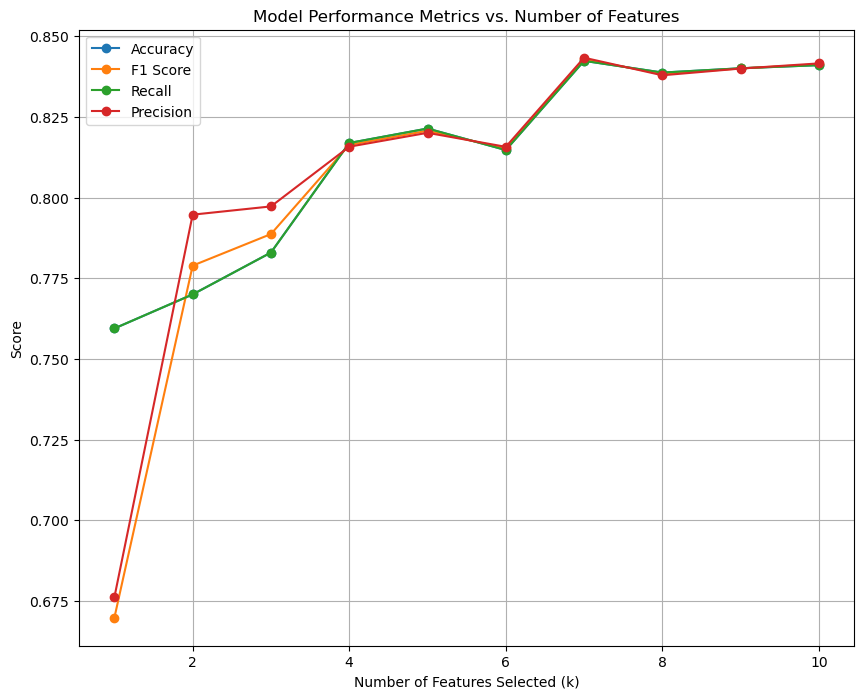

Model   K                                  Selected Featured  acc_metric  \
0   XGB   1                                                age    0.759428   
1   XGB   2             marital-status_Married-civ-spouse, age    0.769977   
2   XGB   3  marital-status_Married-civ-spouse, age, hours-...    0.782951   
3   XGB   4  marital-status_Married-civ-spouse, age, educat...    0.816903   
4   XGB   5  marital-status_Married-civ-spouse, relationshi...    0.821390   
5   XGB   6  marital-status_Married-civ-spouse, marital-sta...    0.814721   
6   XGB   7  marital-status_Married-civ-spouse, marital-sta...    0.842367   
7   XGB   8  marital-status_Married-civ-spouse, marital-sta...    0.838729   
8   XGB   9  marital-status_Married-civ-spouse, marital-sta...    0.840063   
9   XGB  10  marital-status_Married-civ-spouse, marital-sta...    0.841033   

   f1_metric    recall  precision  
0   0.669777  0.759428   0.676118  
1   0.778898  0.769977   0.794693  
2   0.788682  0.782951   0.797250  
3   0.816313  0.816903   0.815759  
4   0.820700  0.821390   0.820063  
5   0.815205  0.814721   0.815714  
6   0.842833  0.842367   0.843333  
7   0.838297  0.838729   0.837891  
8   0.840021  0.840063   0.839979  
9   0.841297  0.841033   0.841572

In [60]:
model_name = ["XGB"]
models = grab_selected_models(model_name)[0]
metric = mutual_info_classif
sample_model = SMOTE()
test_kbest_columns(preprocessor, X, y_encoded, sample_model, models, model_name[0], metric)

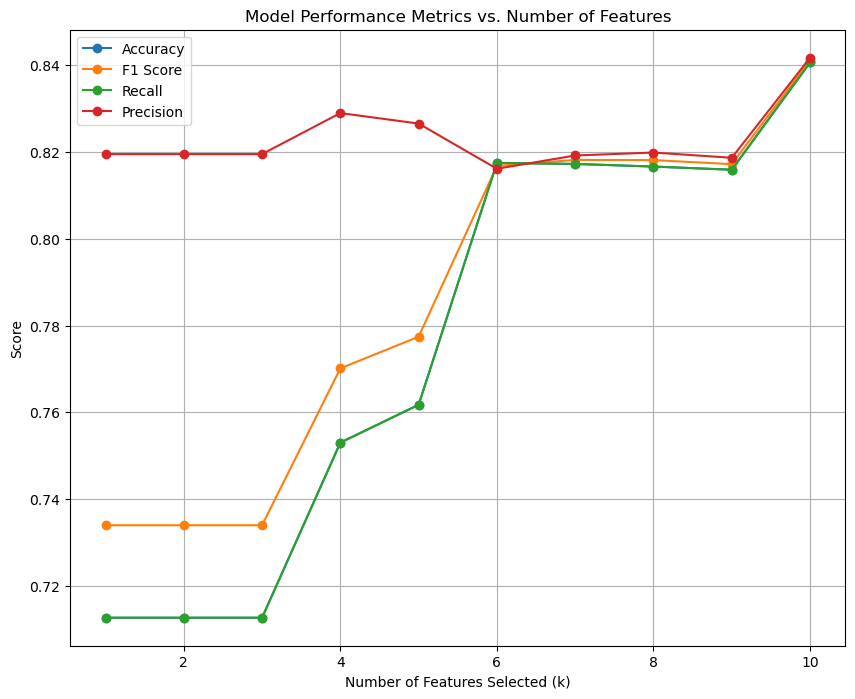

Model   K                                  Selected Featured  acc_metric  \
0   XGB   1                  marital-status_Married-civ-spouse    0.712623   
1   XGB   2  marital-status_Married-civ-spouse, relationshi...    0.712623   
2   XGB   3  marital-status_Married-civ-spouse, marital-sta...    0.712623   
3   XGB   4  marital-status_Married-civ-spouse, marital-sta...    0.753001   
4   XGB   5  marital-status_Married-civ-spouse, marital-sta...    0.761732   
5   XGB   6  marital-status_Married-civ-spouse, marital-sta...    0.817509   
6   XGB   7  marital-status_Married-civ-spouse, marital-sta...    0.817267   
7   XGB   8  marital-status_Married-civ-spouse, marital-sta...    0.816661   
8   XGB   9  marital-status_Married-civ-spouse, marital-sta...    0.815933   
9   XGB  10  marital-status_Married-civ-spouse, marital-sta...    0.840669   

   f1_metric    recall  precision  
0   0.733945  0.712623   0.819537  
1   0.733945  0.712623   0.819537  
2   0.733945  0.712623   0.819537  
3   0.770122  0.753001   0.829000  
4   0.777425  0.761732   0.826577  
5   0.816805  0.817509   0.816152  
6   0.818195  0.817267   0.819219  
7   0.818154  0.816661   0.819896  
8   0.817221  0.815933   0.818691  
9   0.841195  0.840669   0.841763

In [61]:
metric = f_classif
test_kbest_columns(preprocessor, X, y_encoded, sample_model, models, model_name[0], metric)

/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


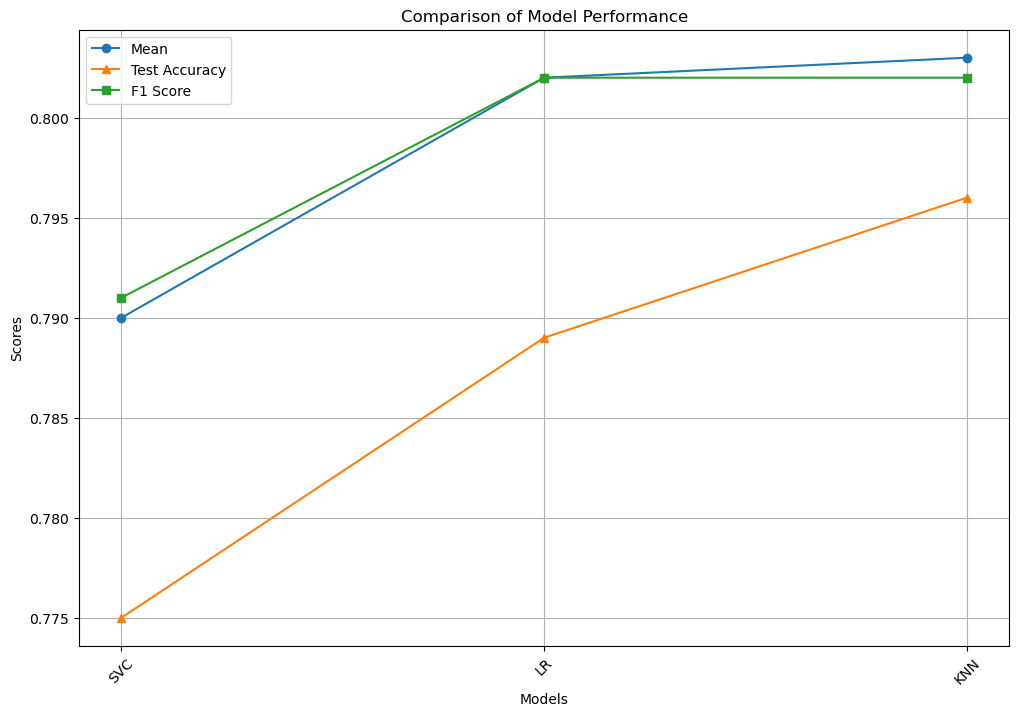

Model   Mean  Var    STD  Test-Acc  recall-Score  precision-Score  F1-Score
2   KNN  0.803  0.0  0.007     0.796         0.796            0.813     0.802
1    LR  0.802  0.0  0.007     0.789         0.789            0.844     0.802
0   SVC  0.790  0.0  0.007     0.775         0.775            0.849     0.791

In [64]:
kbest = SelectKBest(k=7, score_func=mutual_info_classif)
model_names = ["SVC", "LR", "KNN"]
models = grab_selected_models(model_names)
test_selected_models(preprocessor,model_names, models, X, y_encoded, f1_metric, sample_model, kbest)

/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


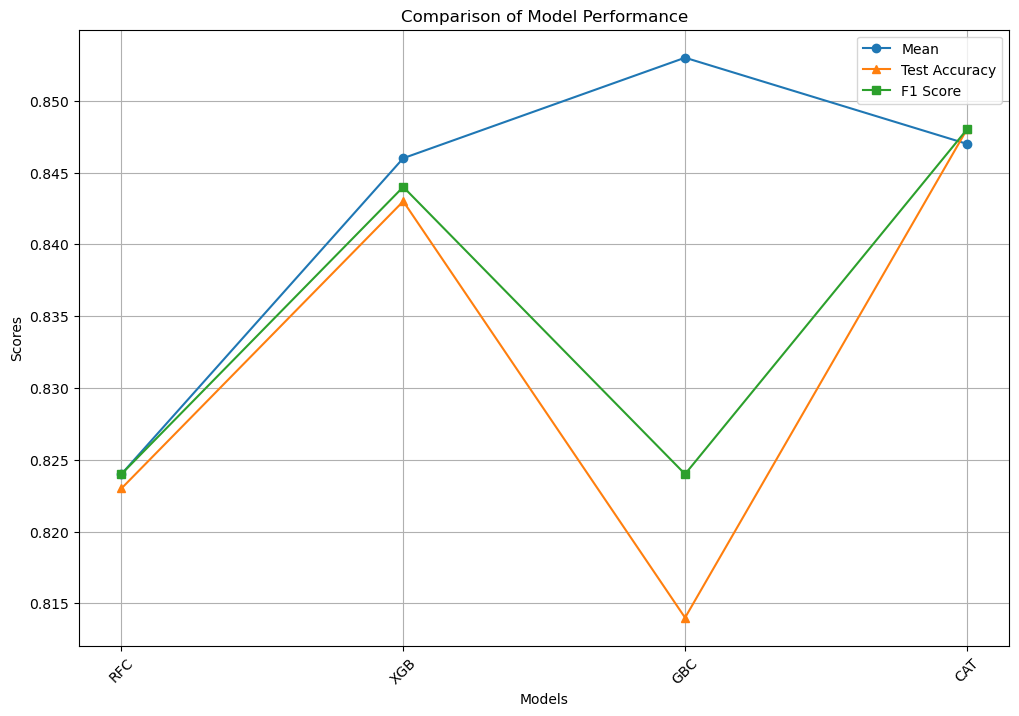

Model   Mean  Var    STD  Test-Acc  recall-Score  precision-Score  F1-Score
2   GBC  0.853  0.0  0.006     0.814         0.814            0.853     0.824
3   CAT  0.847  0.0  0.006     0.848         0.848            0.848     0.848
1   XGB  0.846  0.0  0.007     0.843         0.843            0.846     0.844
0   RFC  0.824  0.0  0.007     0.823         0.823            0.824     0.824

In [63]:
model_names = ["RFC", "XGB", "GBC", "CAT"]
models = grab_selected_models(model_names)
test_selected_models(preprocessor,model_names, models, X, y_encoded, f1_metric, sample_model, kbest)

In [66]:
params = {
    'GBC': {
        'model__n_estimators': [100, 200, 300],
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__max_depth': [3, 4, 5],
        'model__min_samples_split': [2, 4],
        'model__min_samples_leaf': [1, 2]
    },
    'XGB': {
        'model__n_estimators': [100, 150, 200, 300],
        'model__learning_rate': [0.01, 0.02, 0.03, 0.05, 0.1],
        'model__max_depth': [3, 5, 7, 9],
        'model__subsample': [0.3, 0.4, 0.5, 0.6, 0.8, 1.0],
        'model__colsample_bytree': [0.6, 0.8, 1.0]
    },
    'RFC': {
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': [None, 10, 20],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4]
    },
    'SVC': {
        'model__C': [0.1, 1, 10],
        'model__kernel': ['linear', 'rbf'],
        'model__gamma': ['scale', 'auto'],
        'model__degree': [2, 3, 4]
    },
    "CAT":{
    'model__iterations': [100, 500, 1000],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__depth': [4, 6, 10],
    'model__l2_leaf_reg': [1, 3, 5, 7],
    'model__border_count': [32, 64, 128],
    'model__loss_function': ['Logloss', 'CrossEntropy'],
    'model__boosting_type': ['Plain'],
    'model__bootstrap_type': ['Bayesian', 'Bernoulli', 'MVS'],
    'model__grow_policy': ['SymmetricTree', 'Depthwise', 'Lossguide']
}
}

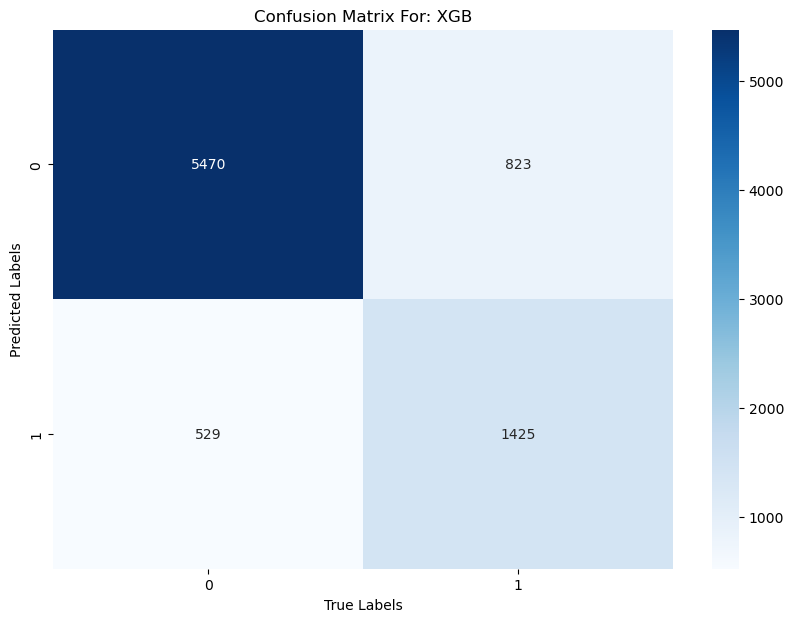

The Best Param: {'model__subsample': 0.6, 'model__n_estimators': 100, 'model__max_depth': 9, 'model__learning_rate': 0.1, 'model__colsample_bytree': 0.8}


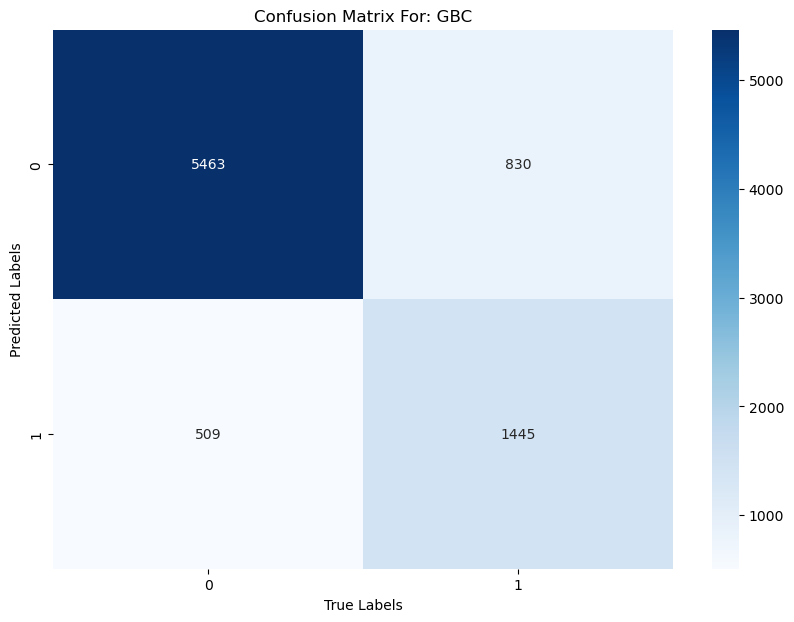

The Best Param: {'model__n_estimators': 100, 'model__min_samples_split': 2, 'model__min_samples_leaf': 1, 'model__max_depth': 4, 'model__learning_rate': 0.2}


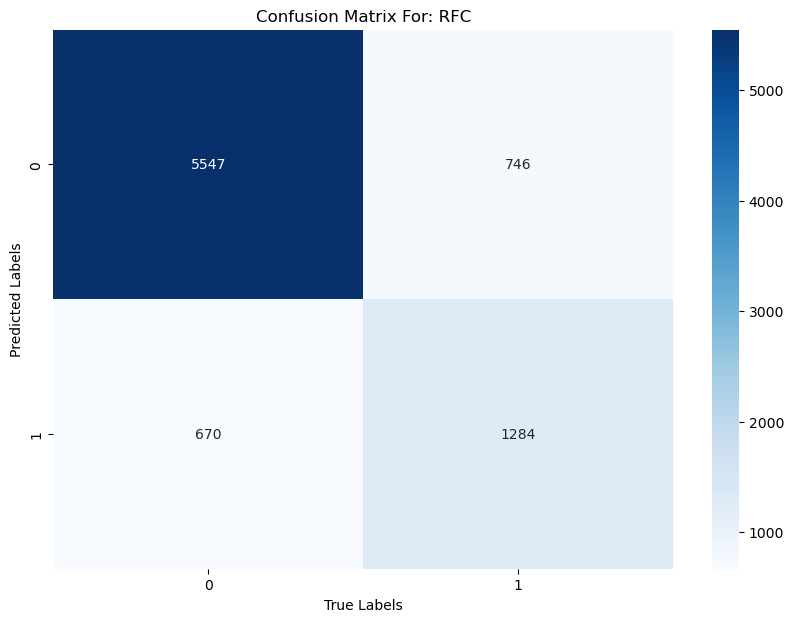

The Best Param: {'model__n_estimators': 300, 'model__min_samples_split': 10, 'model__min_samples_leaf': 1, 'model__max_depth': None}


/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


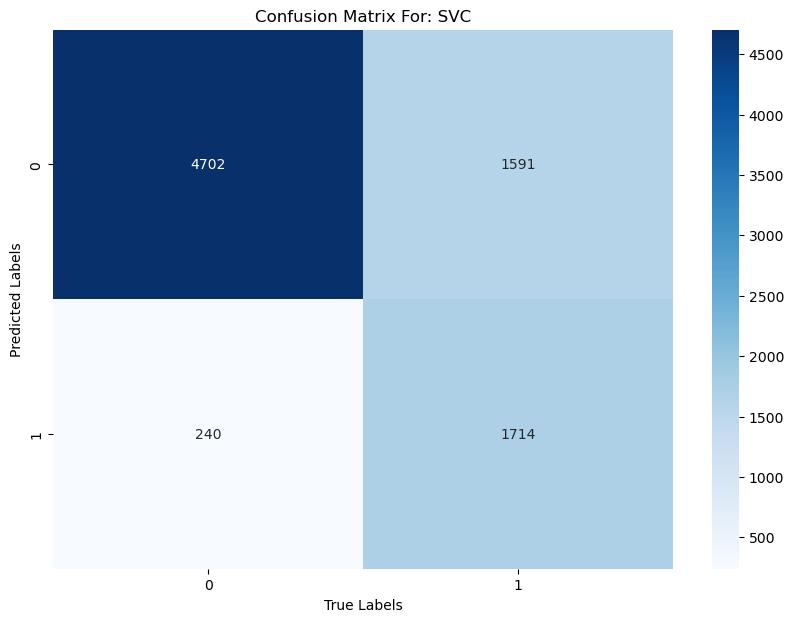

The Best Param: {'model__kernel': 'rbf', 'model__gamma': 'scale', 'model__degree': 4, 'model__C': 10}


/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


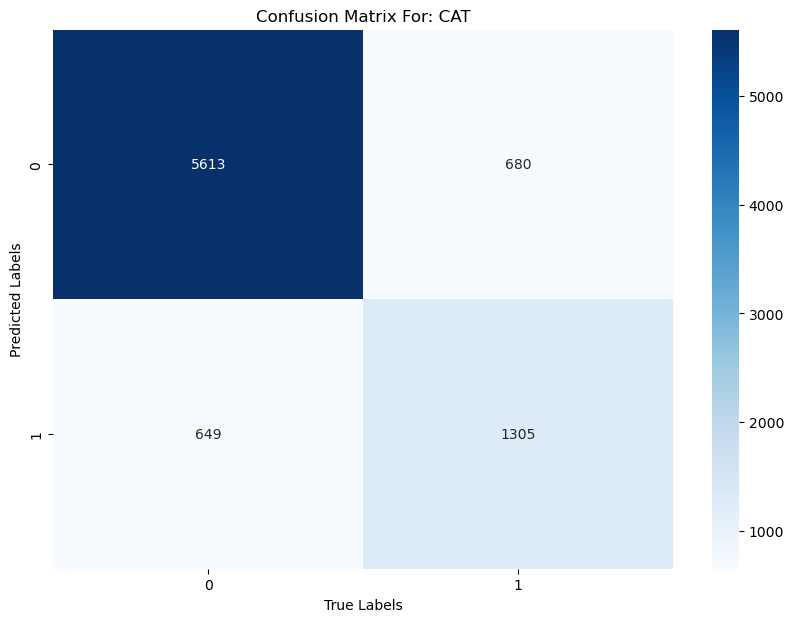

The Best Param: {'model__loss_function': 'Logloss', 'model__learning_rate': 0.05, 'model__l2_leaf_reg': 7, 'model__iterations': 1000, 'model__grow_policy': 'SymmetricTree', 'model__depth': 10, 'model__border_count': 128, 'model__bootstrap_type': 'Bernoulli', 'model__boosting_type': 'Plain'}


Model  Test-Acc  F1-Score  recall-Score  precision-Score
1   GBC  0.837638  0.841675      0.837638         0.848521
0   XGB  0.836062  0.839836      0.836062         0.845969
4   CAT  0.838850  0.839286      0.838850         0.839749
2   RFC  0.828301  0.829417      0.828301         0.830695
3   SVC  0.777980  0.793149      0.777980         0.848885

In [68]:
model_names = ["XGB", "GBC", "RFC", "SVC", "CAT"]
models = grab_selected_models(model_names)
performance_df, best_models = optimization_search(preprocessor, sample_model, model_names, models, X, y_encoded, RandomizedSearchCV, params, f1_metric, kbest)
performance_df.sort_values(by="F1-Score", ascending=False)

# Ensemble Learning

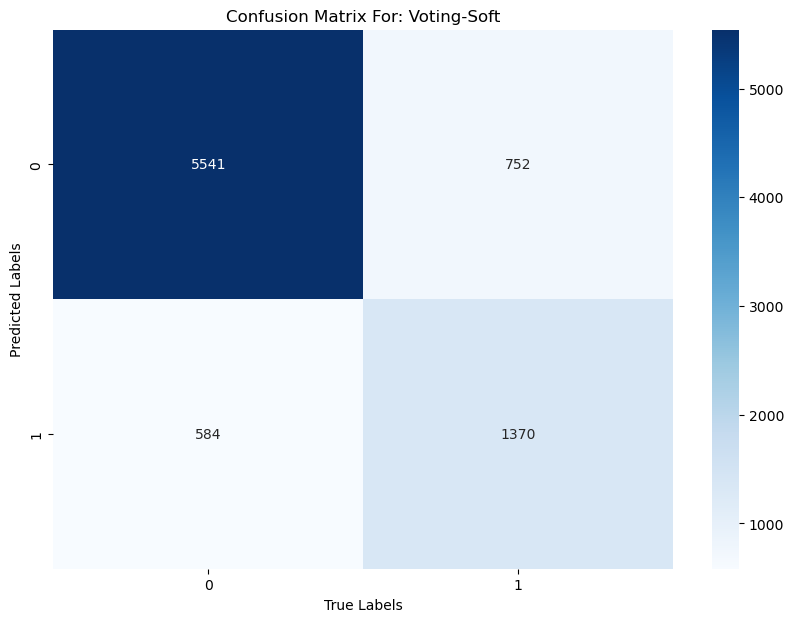

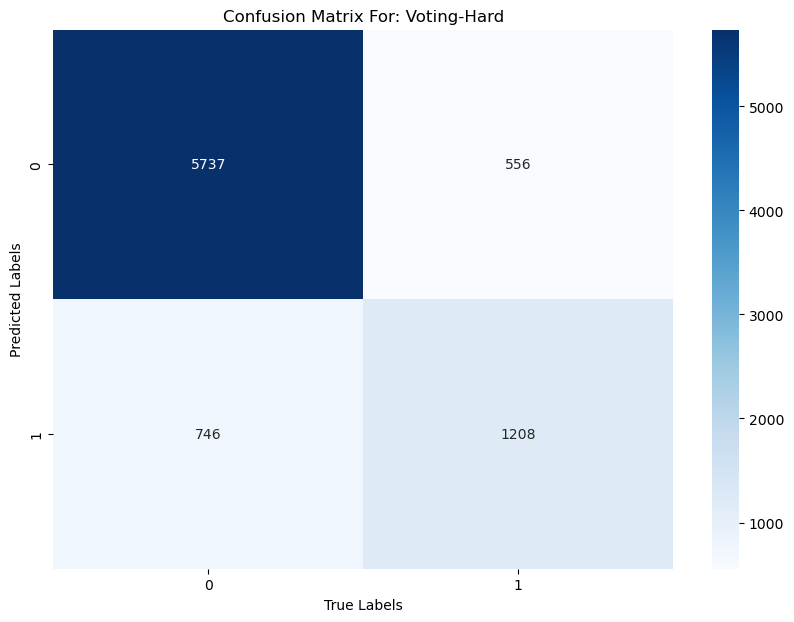

Model  Test-Acc  F1-Score  recall-Score  precision-Score
1  Voting-Hard  0.842124  0.839264      0.842124         0.837514
0  Voting-Soft  0.838002  0.840244      0.838002         0.843279

In [69]:
stack = [
  ("XGB",best_models[0]), 
  ("GBC", best_models[1]), 
  ("RFC", best_models[2]), 
  ("CAT", best_models[4]), 
  ("SVC", best_models[3]),
  ]

voting_hard_clf = VotingClassifier(
  estimators=[
  stack[2],
  stack[0]
  ],
  voting="hard"
)

voting_soft_clf = VotingClassifier(
  estimators=[
  stack[2],
  stack[0]
  ],
  voting="soft"
)

models = [voting_soft_clf, voting_hard_clf]
model_names = ["Voting-Soft", "Voting-Hard"]

test_stacking_models(X, y_encoded, models, model_names)

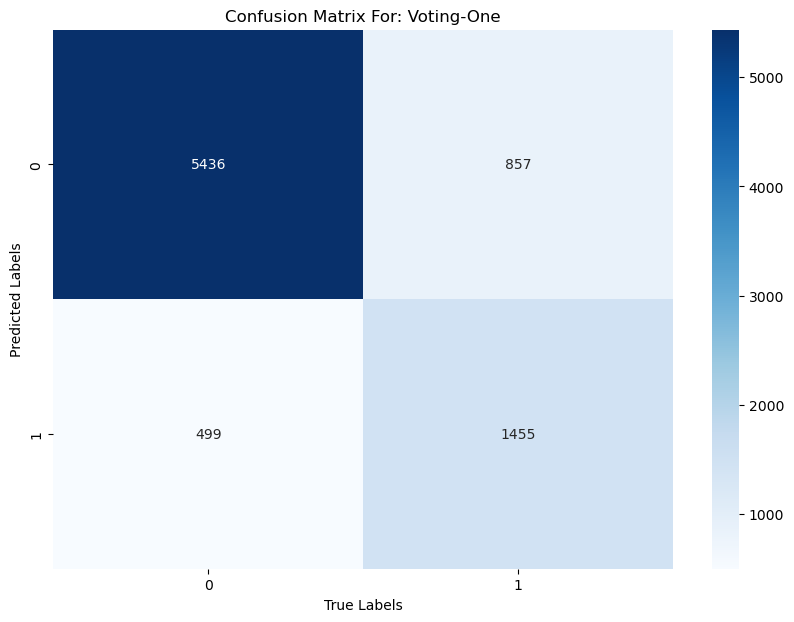

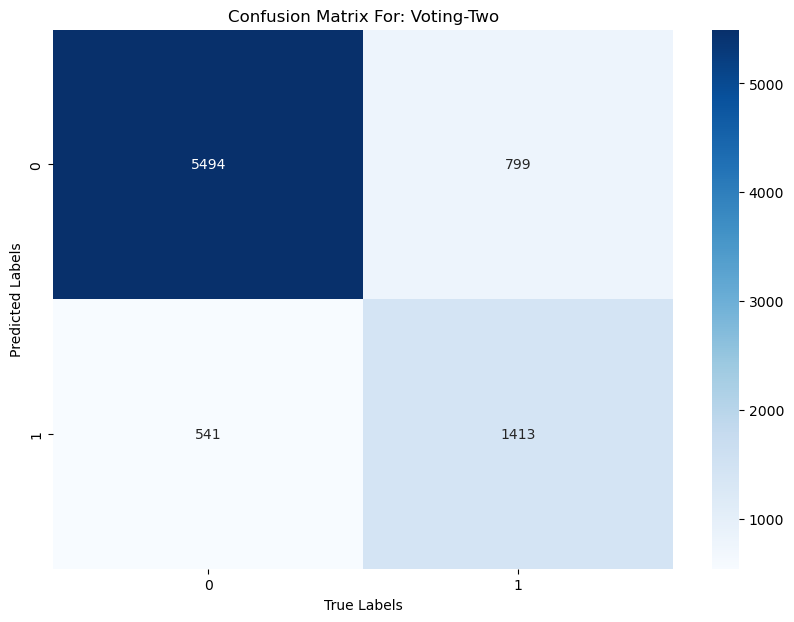

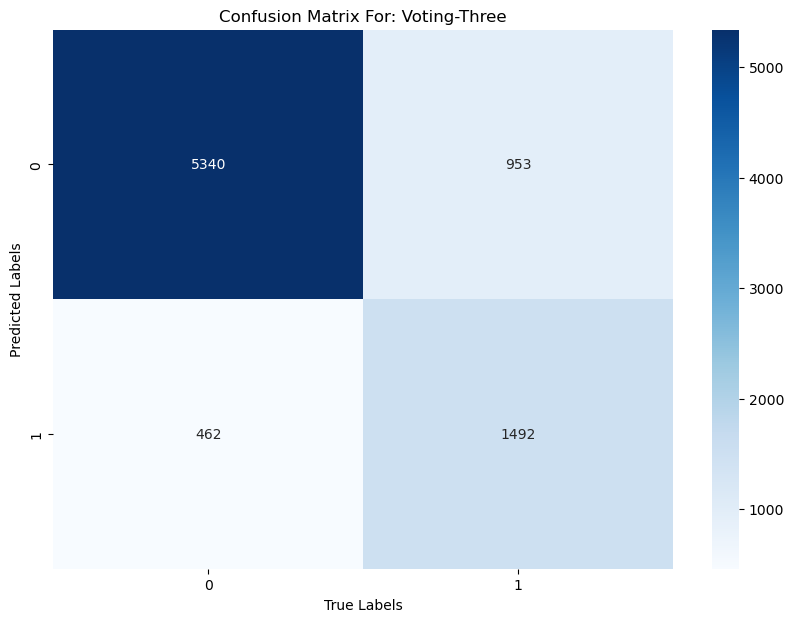

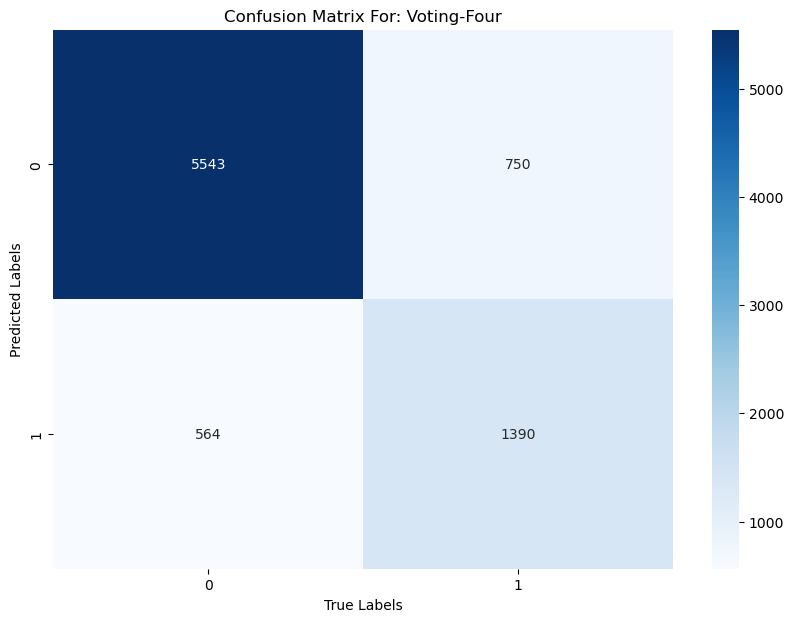

Model  Test-Acc  F1-Score  recall-Score  precision-Score
3   Voting-Four  0.840669  0.843094      0.840669         0.846491
1    Voting-Two  0.837517  0.840848      0.837517         0.846012
0    Voting-One  0.835577  0.840069      0.835577         0.848018
2  Voting-Three  0.828422  0.834515      0.828422         0.846888

In [70]:
voting_one_clf = VotingClassifier(
  estimators=[
  stack[2],
  stack[0],
  stack[3],
  stack[1],
  stack[4]
  ],
  voting="hard"
)

voting_two_clf = VotingClassifier(
  estimators=[
  stack[2],
  stack[0],
  stack[1]
  ],
  voting="hard"
)

voting_three_clf = VotingClassifier(
  estimators=[
  stack[2],
  stack[0],
  stack[3],
  stack[4]
  ],
  voting="soft"
)

voting_four_clf = VotingClassifier(
  estimators=[
  stack[2],
  stack[0],
  stack[3],
  stack[1]
  ],
  voting="soft"
)

models = [voting_one_clf, voting_two_clf, voting_three_clf, voting_four_clf]
model_names = ["Voting-One", "Voting-Two", "Voting-Three", "Voting-Four"]
test_stacking_models(X, y_encoded, models, model_names)

# Best Model Is: Voting Four

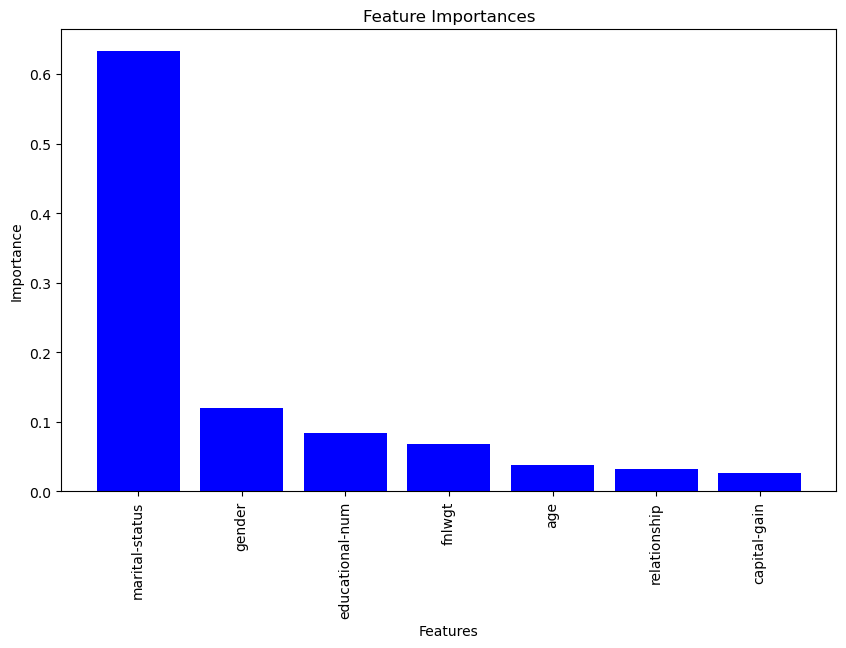

In [71]:
xgb_clf = stack[0][1]
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.33, random_state=42)

xgb_clf.fit(X_train, y_train)
transformed_features = get_feature_names(xgb_clf.named_steps['preprocessor'])
selected_mask = xgb_clf.named_steps['Feature Selection'].get_support()

feature_importances = xgb_clf.named_steps['model'].feature_importances_
all_features = [feature for is_selected, feature in zip(xgb_clf.named_steps['Feature Selection'].get_support(), transformed_features)]


selected_features = [feature for feature, selected in zip(all_features, selected_mask) if selected]
indices = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(len(feature_importances)), feature_importances[indices], color='b')
plt.xticks(range(len(feature_importances)), [all_features[i] for i in indices], rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.show()